2.10.1
True
[]
Akima interpolation hourly → 15-min for column: pressure_msl
Akima interpolation hourly → 15-min for column: surface_pressure
Akima interpolation hourly → 15-min for column: cloud_cover
Akima interpolation hourly → 15-min for column: cloud_cover_low
Akima interpolation hourly → 15-min for column: cloud_cover_mid
Akima interpolation hourly → 15-min for column: cloud_cover_high
Akima interpolation hourly → 15-min for column: vapour_pressure_deficit
Master DF shape: (125951, 40)
Remaining days after cleaning: 1306
Removed days: 6
Total days: 1306
Train days: 1044, Val days: 65, Test days: 197
Train shape: (100224, 46)
Val   shape: (6240, 46)
Test  shape: (18912, 46)

===== FEATURE SELECTION (Two-Stage: Relevance -> Clustering) =====

[Stage-1] Candidate features count: 25

[Stage-1] Top relevance features (head):
                                    feature  abs_corr_to_target
0           global_tilted_irradiance (W/m²)            0.924066
1                shortwave_radiatio

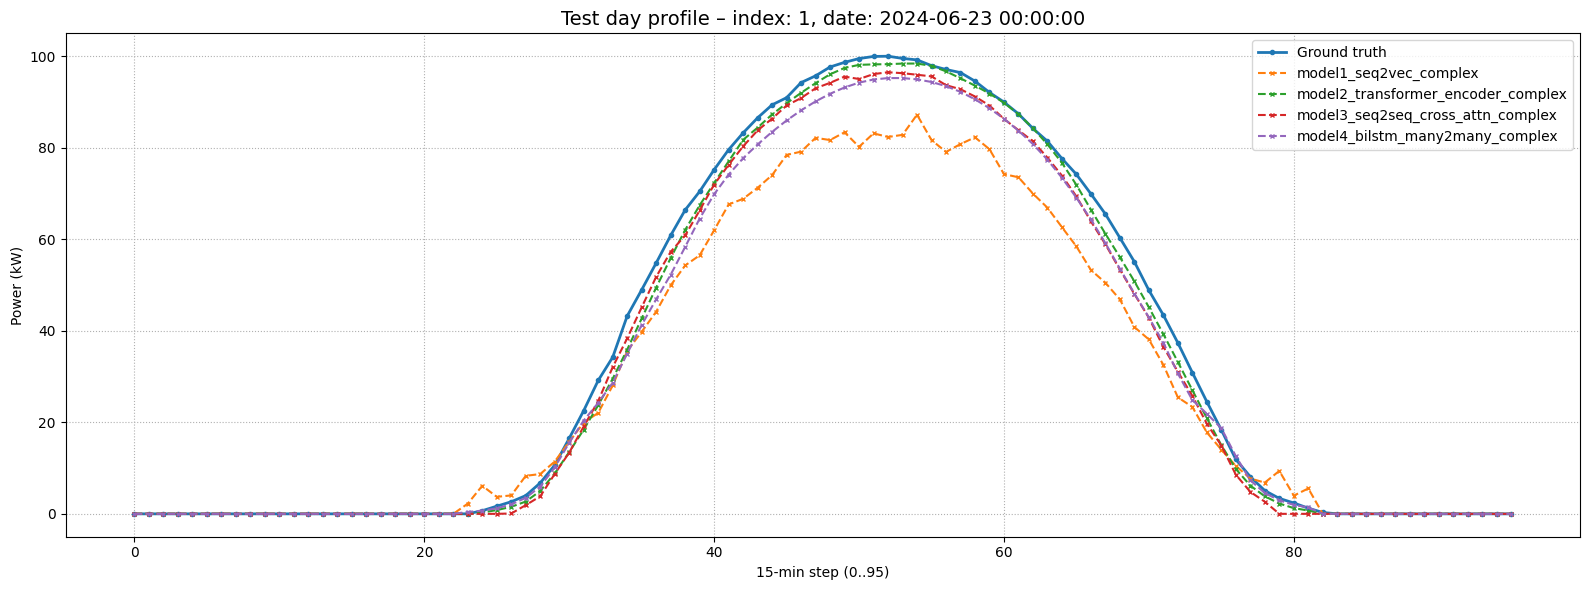


Training finished.
Now you can call, for example:
  pred_df = predict_future_day(forecast_df, model_name=BEST_MODEL_NAME)
or simply:
  pred_df = predict_future_day(forecast_df)   # auto uses best_model.json if exists


In [1]:
# ============================================================
# COMPLEX MODELS (REVIZED) - DAY-AHEAD, 96->96
# Based on your reference pipeline:
#  - Same data pipeline, meteo-only features, day-level split
#  - Increased model complexity (4 models)
#  - Pre-LN Transformer blocks (stable deeper training)
#  - AdamW weight decay (fallback to Adam)
#  - Daylight-weighted training using is_day (sample_weight)
#  - Test metrics computed AFTER deploy-like post-processing (clip_negative + night_zero)
#
# FEATURE SELECTION (REVIZED - TWO-STAGE):
#  1) Relevance prefilter: seçilecek adaylar önce target ile ilişkisine göre (|corr|) filtrelenir
#  2) Redundancy reduction: sadece bu adaylar kendi aralarında benzerliğe göre kümelenir
#  3) Final: mümkünse tam TOP_K_FEATS özellik seçilir (zayıf feature kümeleri hiç hesaba katılmaz)
# ============================================================

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # set BEFORE TF import for GPU selection

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional

from scipy.interpolate import Akima1DInterpolator
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import joblib
import random
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers, callbacks

print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

# optional: avoid TF allocating all GPU memory at once
try:
    gpus = tf.config.list_physical_devices("GPU")
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
except Exception as e:
    print("[Warning] Could not set memory growth:", e)


# --- Reproducibility -------------------------------------------------
GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)

# --- File paths ------------------------------------------------------
PWR_PATH    = r"C:\Users\Admin\Desktop\Vedat\ds_new2.xlsx"
MET_PATH    = r"C:\Users\Admin\Desktop\Vedat\open-meteo_v2.xlsx"
HOURLY_PATH = r"C:\Users\Admin\Desktop\Vedat\python_trials_new\hourly_data\hourly_data_v2.csv"

# Output directory
OUT_DIR = r"C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

MODEL_DIR = os.path.join(OUT_DIR, "models")
os.makedirs(MODEL_DIR, exist_ok=True)

ARTIFACT_DIR = os.path.join(OUT_DIR, "artifacts")
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# --- Timezone and column settings -----------------------------------
TZ_LOCAL   = "Europe/Istanbul"
TARGET_TR  = "Toplam Aktif Güç(kW)"
TARGET_COL = "ActivePower_kW"

# GHI candidates (one of them must exist in df_met or forecast_df)
GHI_CANDIDATES = [
    "shortwave_radiation (W/m²)",
    "global_tilted_irradiance (W/m²)",
    "direct_radiation (W/m²)",
]

# --- Day-level cleaning flags ---------------------------------------
ENABLE_DAILY_GAP_CLEANING = False  # interpolation OFF by default
DAILY_NA_THRESHOLD        = 0.20
MAX_INTERPOLATION_GAP     = 4
EXPECTED_STEPS_PER_DAY    = 96   # 24h * 4 (15-min)

# --- Train/Val/Test ratios (by day) ---------------------------------
TRAIN_RATIO = 0.80
VAL_RATIO   = 0.05   # increased for more stable early-stopping / LR plateau decisions

# --- Day-ahead sequence length --------------------------------------
SEQ_LEN = 96

# --- Feature selection (TWO-STAGE) ----------------------------------
TOP_K_FEATS = 5  # final seçilecek feature sayısı (mümkünse tam K)

# Stage-1: relevance filtresi (target ile zayıf ilişkili feature'ları dışarı at)
MIN_ABS_CORR_TO_TARGET = 0.2  # 0.03–0.10 arası denenebilir

# Stage-1: relevance sonrası aday havuzu (sadece bunlar clustering'e girer)
PRESELECT_TOP_N = 5*TOP_K_FEATS           # genelde 5xK veya 30–80 iyi çalışır

# Stage-2: distance thresholds (distance = 1 - |corr|)
FS_THRESHOLDS = np.unique(np.concatenate([
    np.arange(0.001, 0.021, 0.001),   # çok benzer feature'lar için ince tarama
    np.arange(0.02,  0.101, 0.005),   # orta bölge
    np.arange(0.10,  0.51,  0.05),    # kaba tarama
]))

if PRESELECT_TOP_N < TOP_K_FEATS:
    print("[Warning] PRESELECT_TOP_N < TOP_K_FEATS. K feature seçmek mümkün olmayabilir.")

# --- Plot style ------------------------------------------------------
plt.style.use("default")

# --- Loss function (robust) -----------------------------------------
HUBER_DELTA = 1.0
LOSS_FN = tf.keras.losses.Huber(delta=HUBER_DELTA)

# --- Training stability / generalization aids ------------------------
WEIGHT_DECAY     = 1e-4
DAYLIGHT_WEIGHT  = 3.0   # sample_weight multiplier when is_day==1
CLIP_NEGATIVE    = True  # deploy-like postprocess for evaluation
NIGHT_ZERO       = True  # deploy-like postprocess for evaluation


# ============================================================
# 0b) NOTEBOOK/JUPYTER FIX: Safe register decorator
# ============================================================

def register_keras_serializable_once(package: str, name: str = None):
    """
    Notebook/Jupyter uyumlu register:
    - Aynı isim daha önce register edildiyse hata vermek yerine mevcut kayıtlı class'ı döndürür.
    - Eğer custom layer kodunu değiştirip tekrar çalıştırıyorsanız, en temiz yol kernel restart'tır.
    """
    def decorator(cls):
        reg_name = f"{package}>{name or cls.__name__}"
        try:
            return tf.keras.utils.register_keras_serializable(package=package, name=name)(cls)
        except ValueError as e:
            msg = str(e)
            if "has already been registered" in msg:
                existing = tf.keras.utils.get_custom_objects().get(reg_name)
                if existing is not None:
                    return existing
            raise
    return decorator


# ============================================================
# 1) DATA LOADING, AKIMA INTERPOLATION, TIMEZONE ALIGNMENT
# ============================================================

def akima_interpolate_series(time_old, values_old, time_new):
    values_old = np.asarray(values_old, dtype=float)
    mask = ~np.isnan(values_old)
    time_old_clean = time_old[mask]
    values_old_clean = values_old[mask]

    x_old = time_old_clean.astype("datetime64[ns]").astype(np.int64)
    x_new = time_new.astype("datetime64[ns]").astype(np.int64)

    if len(x_old) < 3:
        return np.interp(x_new, x_old, values_old_clean)

    f = Akima1DInterpolator(x_old, values_old_clean)
    return f(x_new)


def load_and_build_master_df():
    # --- Power (15-min) --------------------------------------
    df_pwr = pd.read_excel(PWR_PATH)
    df_pwr["Zaman"] = pd.to_datetime(df_pwr["Zaman"])
    df_pwr.set_index("Zaman", inplace=True)
    df_pwr.sort_index(inplace=True)

    if TARGET_TR in df_pwr.columns:
        df_pwr = df_pwr.rename(columns={TARGET_TR: TARGET_COL})
    elif TARGET_COL not in df_pwr.columns:
        raise KeyError(f"Power column not found: {TARGET_TR} or {TARGET_COL}")

    # --- Meteo (15-min) --------------------------------------
    df_met = pd.read_excel(MET_PATH)
    df_met["time"] = pd.to_datetime(df_met["time"])
    df_met.set_index("time", inplace=True)
    df_met.sort_index(inplace=True)

    # --- Hourly meteo ----------------------------------------
    df_hourly = pd.read_csv(HOURLY_PATH)
    if "time" not in df_hourly.columns:
        raise KeyError("'time' column not found in hourly CSV.")
    df_hourly["time"] = pd.to_datetime(df_hourly["time"])
    df_hourly.set_index("time", inplace=True)
    df_hourly.sort_index(inplace=True)

    hourly_cols = [
        "pressure_msl",
        "surface_pressure",
        "cloud_cover",
        "cloud_cover_low",
        "cloud_cover_mid",
        "cloud_cover_high",
        "vapour_pressure_deficit",
    ]
    for c in hourly_cols:
        if c not in df_hourly.columns:
            print(f"[Warning] Hourly column missing: {c}")
    hourly_df = df_hourly[[c for c in hourly_cols if c in df_hourly.columns]].copy()

    # --- Hourly -> 15-min via Akima ---------------------------
    target_index = df_met.index.sort_values().unique()
    df_hourly_15 = pd.DataFrame(index=target_index)
    for col in hourly_df.columns:
        print(f"Akima interpolation hourly → 15-min for column: {col}")
        df_hourly_15[col] = akima_interpolate_series(
            hourly_df.index.values,
            hourly_df[col].values,
            target_index.values
        )

    # --- Timezone alignment ----------------------------------
    # meteo & hourly are assumed UTC; convert to local and drop tz
    df_met.index = (
        df_met.index
        .tz_localize("UTC")
        .tz_convert(TZ_LOCAL)
        .tz_localize(None)
    )
    df_hourly_15.index = (
        df_hourly_15.index
        .tz_localize("UTC")
        .tz_convert(TZ_LOCAL)
        .tz_localize(None)
    )

    # power is assumed local naive; localize->convert->drop tz
    df_pwr.index = (
        df_pwr.index
        .tz_localize(TZ_LOCAL)
        .tz_convert(TZ_LOCAL)
        .tz_localize(None)
    )

    # --- Join meteo + hourly + power -------------------------
    df = (
        df_met.join(df_hourly_15, how="inner")
              .join(df_pwr[[TARGET_COL]], how="inner")
              .sort_index()
    )

    # Optional drop (you had this before)
    first_day_to_drop = pd.to_datetime("2021-03-24").date()
    df = df[df.index.date != first_day_to_drop]

    # Determine GHI column
    ghi_col = None
    for c in GHI_CANDIDATES:
        if c in df.columns:
            ghi_col = c
            break
    if ghi_col is None:
        raise KeyError(f"No GHI-like column found among {GHI_CANDIDATES}")

    # Create 'is_day' if missing
    if "is_day" not in df.columns:
        df["is_day"] = (df[ghi_col] > 0).astype(int)

    # Add 'day' column
    df["day"] = df.index.normalize()

    print("Master DF shape:", df.shape)
    return df, ghi_col


# ============================================================
# 2) DAY-LEVEL CLEANING
# ============================================================

def clean_days_with_power_gaps(
    df,
    power_col=TARGET_COL,
    enable_gap_cleaning=ENABLE_DAILY_GAP_CLEANING,
    daily_na_threshold=DAILY_NA_THRESHOLD,
    max_interp_gap=MAX_INTERPOLATION_GAP,
    expected_steps_per_day=EXPECTED_STEPS_PER_DAY,
):
    keep_groups = []
    removed_days = []

    for day, g in df.groupby("day"):
        g = g.sort_index().copy()
        y = g[power_col].astype(float)

        # 1) Check number of steps per day
        if len(g) != expected_steps_per_day:
            removed_days.append((day, "wrong_length", len(g)))
            continue

        # 2) Drop days with too many zeros
        zero_ratio = (y == 0).mean()
        if zero_ratio > 0.80:
            removed_days.append((day, "too_many_zeros", float(zero_ratio)))
            continue

        # 3) NaN handling for power
        na_ratio = y.isna().mean()
        if not enable_gap_cleaning:
            if na_ratio > 0.0:
                removed_days.append((day, "has_nan_no_cleaning", float(na_ratio)))
                continue
        else:
            if na_ratio > daily_na_threshold:
                removed_days.append((day, "na_ratio_too_high", float(na_ratio)))
                continue

            y_interp = y.interpolate(limit=max_interp_gap, limit_direction="both")
            if y_interp.isna().any():
                removed_days.append((day, "nan_after_interp", float(y_interp.isna().mean())))
                continue
            g[power_col] = y_interp

        keep_groups.append(g)

    if not keep_groups:
        raise RuntimeError("No valid days left after cleaning. Check thresholds.")

    df_clean = pd.concat(keep_groups).sort_index()
    print(f"Remaining days after cleaning: {df_clean['day'].nunique()}")
    print(f"Removed days: {len(removed_days)}")
    return df_clean, removed_days


# ============================================================
# 2b) FEATURE ENGINEERING (METEO-ONLY; DEPLOY-SAFE)
# ============================================================

def add_feature_engineering_meteo_only(df, ghi_col):
    """
    Deploy-safe: Sadece meteoroloji + timestamp'ten üretilebilen feature'lar.
    Target/power'a (veya geleceğe) bakan hiçbir lag/prev-day target feature YOK.
    """
    df = df.copy()
    idx = df.index

    if "day" not in df.columns:
        df["day"] = idx.normalize()

    # Create 'is_day' if missing
    if "is_day" not in df.columns:
        if ghi_col not in df.columns:
            # fallback: search any GHI candidate
            found = None
            for c in GHI_CANDIDATES:
                if c in df.columns:
                    found = c
                    break
            if found is None:
                raise KeyError(f"Cannot build is_day: no ghi column found among {GHI_CANDIDATES}")
            ghi_col = found
        df["is_day"] = (df[ghi_col] > 0).astype(int)

    # Day-of-year (cyclical)
    doy = idx.dayofyear
    df["doy_sin"] = np.sin(2 * np.pi * (doy / 365.0))
    df["doy_cos"] = np.cos(2 * np.pi * (doy / 365.0))

    # Time-of-day (cyclical)
    minute_of_day = idx.hour * 60 + idx.minute
    df["tod_sin"] = np.sin(2 * np.pi * (minute_of_day / 1440.0))
    df["tod_cos"] = np.cos(2 * np.pi * (minute_of_day / 1440.0))

    # Slot (0..95)
    minutes = (idx - idx.normalize()) / pd.Timedelta(minutes=15)
    df["slot"] = minutes.astype(int)

    # Clear-sky-like index: GHI / daily max GHI
    if ghi_col not in df.columns:
        raise KeyError(f"ghi_col='{ghi_col}' not found in df for cs_index feature.")
    ghi = df[ghi_col].astype(float)
    daily_max_ghi = df.groupby("day")[ghi_col].transform("max").replace(0, np.nan)
    cs_index = (ghi / daily_max_ghi).replace([np.inf, -np.inf], np.nan)
    df["cs_index_dailymax"] = cs_index.clip(0, 5).fillna(0.0)

    return df


# ============================================================
# 2c) FEATURE SELECTION (TWO-STAGE: RELEVANCE -> CLUSTERING)
# ============================================================

def compute_abs_target_corr(df, target_col, feature_cols) -> pd.Series:
    """
    Train üzerinde |corr(feature, target)| skorları.
    """
    y = df[target_col].astype(float)
    scores = {}

    for c in feature_cols:
        x = df[c]
        if not np.issubdtype(x.dtype, np.number):
            continue
        x = pd.to_numeric(x, errors="coerce")
        corr = x.corr(y)
        if pd.isna(corr):
            continue
        scores[c] = float(abs(corr))

    if not scores:
        return pd.Series(dtype=float)

    return pd.Series(scores).sort_values(ascending=False)


def preselect_candidate_features(df, target_col, feature_cols,
                                 top_n=PRESELECT_TOP_N,
                                 min_abs_corr=MIN_ABS_CORR_TO_TARGET):
    """
    Stage-1 (Relevance):
      - |corr| < min_abs_corr olanları at
      - kalanlardan top_n taneyi aday havuzu yap
    """
    s = compute_abs_target_corr(df, target_col, feature_cols)

    if len(s) == 0:
        return [], s

    if min_abs_corr is not None:
        s = s[s >= float(min_abs_corr)]

    if top_n is not None and len(s) > int(top_n):
        s = s.head(int(top_n))

    return s.index.tolist(), s


def build_distance_and_linkage(df, feature_cols):
    """
    Aday feature'lar arası abs corr -> distance -> linkage.
    distance = 1 - abs(corr)
    """
    corr = df[feature_cols].corr().abs().fillna(0.0)
    distance = 1.0 - corr
    np.fill_diagonal(distance.values, 0.0)

    Z = linkage(squareform(distance.values), method="average")
    return distance, Z


def clusters_from_linkage(Z, threshold):
    """
    Linkage Z + distance threshold ile cluster id üret.
    """
    clusters = fcluster(Z, t=float(threshold), criterion="distance")
    return clusters


def select_reps_from_clusters(feature_cols, cluster_ids, target_corr_abs: pd.Series):
    """
    Her kümeden target ile en yüksek |corr| olan feature'ı seç.
    """
    cluster_table = pd.DataFrame({
        "feature": feature_cols,
        "cluster_id": cluster_ids
    })

    reps = []
    for cid in sorted(cluster_table["cluster_id"].unique()):
        members = cluster_table.loc[cluster_table["cluster_id"] == cid, "feature"].tolist()
        # güvenlik: target_corr_abs'ta olmayan olursa 0 say
        best_f = max(members, key=lambda f: float(target_corr_abs.get(f, 0.0)))
        reps.append(best_f)

    return reps, cluster_table


def auto_threshold_for_k(Z, thresholds, target_k, candidate_n):
    """
    Amaç: reps sayısı >= K olacak şekilde K'ya en yakın threshold'u seçmek.
    Z linkage üzerinden hızlıca n_clusters sayar.
    """
    rows = []

    if candidate_n <= target_k:
        table = pd.DataFrame([{
            "threshold": None,
            "corr_limit": None,
            "n_clusters": int(candidate_n),
            "note": f"candidate_n({candidate_n}) <= target_k({target_k})"
        }])
        return None, table

    for th in thresholds:
        cl = clusters_from_linkage(Z, th)
        n_clusters = int(len(np.unique(cl)))
        rows.append({
            "threshold": float(round(th, 6)),
            "corr_limit": float(round(1.0 - th, 6)),
            "n_clusters": n_clusters
        })

    table = pd.DataFrame(rows)

    feasible = table[table["n_clusters"] >= int(target_k)].copy()
    if len(feasible) == 0:
        # hiç K'ya ulaşamadıysa: maksimum cluster sayısı veren threshold
        best_row = table.sort_values(["n_clusters", "threshold"], ascending=[False, True]).iloc[0]
    else:
        feasible["err"] = feasible["n_clusters"] - int(target_k)
        # K'ya en yakın (üstten), tie-break: daha büyük threshold (daha çok merge) tercih
        best_row = feasible.sort_values(["err", "threshold"], ascending=[True, False]).iloc[0]

    return float(best_row["threshold"]), table


def two_stage_feature_selection(df_train, target_col, feature_cols_all,
                                top_k=TOP_K_FEATS,
                                preselect_top_n=PRESELECT_TOP_N,
                                min_abs_corr=MIN_ABS_CORR_TO_TARGET,
                                thresholds=FS_THRESHOLDS):
    """
    1) Relevance filtresi (|corr(feature,target)|)
    2) Sadece adaylar üzerinde clustering (redundancy azaltma)
    3) Final: mümkünse tam top_k feature
    """
    # ---- Stage-1: relevance ----
    candidates, rel_scores = preselect_candidate_features(
        df=df_train,
        target_col=target_col,
        feature_cols=feature_cols_all,
        top_n=preselect_top_n,
        min_abs_corr=min_abs_corr
    )

    # Eğer filtre çok sertse: min_abs_corr'ı devre dışı bırakıp sadece top_n al
    if len(candidates) == 0:
        candidates, rel_scores = preselect_candidate_features(
            df=df_train,
            target_col=target_col,
            feature_cols=feature_cols_all,
            top_n=preselect_top_n,
            min_abs_corr=None
        )

    # Hâlâ boşsa: feature selection yapılamaz
    if len(candidates) == 0:
        raise RuntimeError("Feature selection failed: no numeric candidate features found with valid correlation.")

    # Aday sayısı zaten K'dan az/eşit
    if len(candidates) <= int(top_k):
        final_feats = candidates
        debug = {
            "candidates": candidates,
            "rel_scores": rel_scores,
            "best_threshold": None,
            "threshold_table": pd.DataFrame(),
            "cluster_table": pd.DataFrame(),
            "target_corr_candidates": rel_scores,
            "distance": None,
            "Z": None
        }
        return final_feats, debug

    # ---- Stage-2: clustering ----
    # target corr abs (candidates)
    target_corr_abs = compute_abs_target_corr(df_train, target_col, candidates).reindex(candidates).fillna(0.0)

    distance, Z = build_distance_and_linkage(df_train, candidates)

    best_th, th_table = auto_threshold_for_k(
        Z=Z,
        thresholds=thresholds,
        target_k=int(top_k),
        candidate_n=len(candidates)
    )

    cluster_ids = clusters_from_linkage(Z, best_th)
    reps, cluster_table = select_reps_from_clusters(candidates, cluster_ids, target_corr_abs)

    # reps'i target corr'a göre sırala
    reps_sorted = sorted(reps, key=lambda f: float(target_corr_abs.get(f, 0.0)), reverse=True)

    # Final: normalde reps >= K seçilecek şekilde threshold seçildi,
    # ama yine de güvenlik için fallback koyuyoruz.
    final_feats = reps_sorted[:int(top_k)]

    if len(final_feats) < int(top_k) and len(candidates) >= int(top_k):
        # fallback: reps yetmezse, candidates içinden target_corr'a göre ekle
        all_sorted = sorted(candidates, key=lambda f: float(target_corr_abs.get(f, 0.0)), reverse=True)
        for f in all_sorted:
            if f not in final_feats:
                final_feats.append(f)
            if len(final_feats) == int(top_k):
                break

    debug = {
        "candidates": candidates,
        "rel_scores": rel_scores,                 # Stage-1 relevance skorları
        "best_threshold": best_th,
        "threshold_table": th_table,
        "cluster_table": cluster_table,
        "target_corr_candidates": target_corr_abs,
        "distance": distance,
        "Z": Z
    }
    return final_feats, debug


# ============================================================
# 3) TRAIN/VAL/TEST SPLIT BY DAY
# ============================================================

def split_days_train_val_test(df, train_ratio=TRAIN_RATIO, val_ratio=VAL_RATIO):
    unique_days = np.array(sorted(df["day"].unique()))
    n_days = len(unique_days)

    n_train = max(1, int(n_days * train_ratio))
    n_val   = max(1, int(n_days * val_ratio))

    days_train = unique_days[:n_train]
    days_val   = unique_days[n_train:n_train + n_val]
    days_test  = unique_days[n_train + n_val:]

    print(f"Total days: {n_days}")
    print(f"Train days: {len(days_train)}, Val days: {len(days_val)}, Test days: {len(days_test)}")
    return days_train, days_val, days_test


# ============================================================
# 4) DAY-LEVEL DATASET CREATION (X: 96xF, y: 96x1 per day)
#    + returns is_day mask and daylight sample_weight
# ============================================================

def create_day_level_dataset(
    df,
    feature_cols,
    target_col=TARGET_COL,
    expected_steps=EXPECTED_STEPS_PER_DAY,
    is_day_col="is_day",
    daylight_weight=DAYLIGHT_WEIGHT,
):
    X_list, y_list, day_list = [], [], []
    is_day_list, sw_list = [], []

    for day, g in df.groupby("day"):
        g = g.sort_index()

        if len(g) != expected_steps:
            continue

        needed_cols = list(feature_cols) + [target_col]
        if g[needed_cols].isna().any().any():
            continue

        X = g[feature_cols].values.astype(np.float32)   # (96, F)
        y = g[[target_col]].values.astype(np.float32)   # (96, 1)

        # is_day (96,)
        if is_day_col in g.columns:
            is_day = g[is_day_col].values.astype(np.float32)
        else:
            # fallback: no is_day => all ones
            is_day = np.ones((expected_steps,), dtype=np.float32)

        # sample_weight: night=1.0, day=daylight_weight
        sw = 1.0 + (daylight_weight - 1.0) * is_day

        X_list.append(X)
        y_list.append(y)
        day_list.append(day)
        is_day_list.append(is_day.astype(np.int8))
        sw_list.append(sw.astype(np.float32))

    if not X_list:
        return None, None, None, None, None

    X_arr      = np.stack(X_list, axis=0)              # (N,96,F)
    y_arr      = np.stack(y_list, axis=0)              # (N,96,1)
    day_arr    = np.array(day_list)                    # (N,)
    is_day_arr = np.stack(is_day_list, axis=0)         # (N,96)
    sw_arr     = np.stack(sw_list, axis=0)             # (N,96)

    return X_arr, y_arr, day_arr, is_day_arr, sw_arr


# ============================================================
# 5) METRICS + PLOT
# ============================================================

def compute_overall_metrics(y_true, y_pred, mask=None):
    """
    y_true, y_pred: (N,96,1) or flattenable
    mask: (N,96) 0/1 or bool => metrics only on mask==1
    """
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)

    if mask is not None:
        m = mask.reshape(-1).astype(bool)
        y_true_flat = y_true_flat[m]
        y_pred_flat = y_pred_flat[m]

    mse  = mean_squared_error(y_true_flat, y_pred_flat)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true_flat, y_pred_flat)
    r2   = r2_score(y_true_flat, y_pred_flat)

    return {"MSE": float(mse), "RMSE": float(rmse), "MAE": float(mae), "R2": float(r2)}


def compute_daily_metrics(day_array, Y_true, Y_pred):
    records = []
    unique_days = np.unique(day_array)
    for d in unique_days:
        idx = np.where(day_array == d)[0]
        y_t = Y_true[idx].reshape(-1)
        y_p = Y_pred[idx].reshape(-1)

        mse_d  = mean_squared_error(y_t, y_p)
        rmse_d = np.sqrt(mse_d)
        mae_d  = mean_absolute_error(y_t, y_p)
        r2_d   = r2_score(y_t, y_p)

        records.append({"day": d, "MSE": float(mse_d), "RMSE": float(rmse_d), "MAE": float(mae_d), "R2": float(r2_d)})

    return pd.DataFrame(records).set_index("day")


def postprocess_predictions(y_pred_orig, is_day_arr=None, clip_negative=True, night_zero=True, capacity_kw=None):
    """
    y_pred_orig: (N,96,1) expected (or (N,96))
    is_day_arr:  (N,96) 0/1
    """
    y = np.array(y_pred_orig, copy=True)

    # ensure 2D for easy masking then restore
    squeezed = False
    if y.ndim == 3 and y.shape[-1] == 1:
        y = y.squeeze(-1)
        squeezed = True

    if clip_negative:
        y = np.maximum(y, 0.0)

    if night_zero and is_day_arr is not None:
        night_mask = (is_day_arr.astype(int) == 0)
        y[night_mask] = 0.0

    if capacity_kw is not None:
        y = np.clip(y, 0.0, float(capacity_kw))

    if squeezed:
        y = y[..., np.newaxis]  # back to (N,96,1)

    return y


def plot_test_day(day_no, d_test, Y_test_orig, preds_by_model, model_list=None):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return

    if model_list is None:
        model_list = list(preds_by_model.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = Y_test_orig[idxs].reshape(-1)

    plt.figure(figsize=(16, 6))
    plt.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model:
            continue
        y_pred_day = preds_by_model[model_name][idxs].reshape(-1)
        plt.plot(y_pred_day, label=f"{model_name}", linestyle="--", marker="x", ms=3)

    plt.title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=14)
    plt.xlabel("15-min step (0..95)")
    plt.ylabel("Power (kW)")
    plt.grid(True, linestyle=":")
    plt.legend()
    plt.tight_layout()
    plt.show()


# ============================================================
# 6) TRANSFORMER HELPERS + SERIALIZABLE CUSTOM LAYERS (REVIZED)
#    - Pre-LN encoder/decoder blocks for deep stability
#    - GELU activation in FFN
# ============================================================

def positional_encoding_1d(position, d_model):
    def get_angles(pos, i, d_model_inner):
        angle_rates = 1.0 / np.power(10000, (2 * (i // 2)) / np.float32(d_model_inner))
        return pos * angle_rates

    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])

    pe = np.zeros((position, d_model))
    pe[:, 0::2] = sines
    pe[:, 1::2] = cosines
    return pe


@register_keras_serializable_once(package="day_ahead")
class PositionalEncodingLayer(layers.Layer):
    def __init__(self, max_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.max_len = int(max_len)
        self.d_model = int(d_model)
        pe = positional_encoding_1d(self.max_len, self.d_model)
        self.pos_encoding = tf.constant(pe[np.newaxis, ...], dtype=tf.float32)

    def call(self, x, training=None):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]

    def get_config(self):
        config = super().get_config()
        config.update({"max_len": self.max_len, "d_model": self.d_model})
        return config


@register_keras_serializable_once(package="day_ahead", name="TransformerEncoderBlockPreLN")
class TransformerEncoderBlockPreLN(layers.Layer):
    """
    Pre-LN Transformer Encoder block:
      x -> LN -> MHA -> dropout -> residual
        -> LN -> FFN(GELU) -> dropout -> residual
    """
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = int(d_model)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.dropout = float(dropout)

        if self.d_model % self.num_heads != 0:
            raise ValueError(f"d_model ({self.d_model}) must be divisible by num_heads ({self.num_heads}).")

        key_dim = self.d_model // self.num_heads

        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)

        self.mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=key_dim,
            dropout=self.dropout
        )

        self.ffn = tf.keras.Sequential([
            layers.Dense(self.ff_dim, activation=tf.keras.activations.gelu),
            layers.Dropout(self.dropout),
            layers.Dense(self.d_model),
        ])

        self.do1 = layers.Dropout(self.dropout)
        self.do2 = layers.Dropout(self.dropout)

    def call(self, x, training=None):
        x_norm = self.ln1(x)
        attn = self.mha(x_norm, x_norm, x_norm, training=training)
        attn = self.do1(attn, training=training)
        x = x + attn

        x_norm2 = self.ln2(x)
        ffn = self.ffn(x_norm2, training=training)
        ffn = self.do2(ffn, training=training)
        x = x + ffn
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout
        })
        return config


@register_keras_serializable_once(package="day_ahead", name="TransformerDecoderBlockPreLN")
class TransformerDecoderBlockPreLN(layers.Layer):
    """
    Pre-LN Transformer Decoder block:
      x -> LN -> self-MHA -> dropout -> residual
        -> LN -> cross-MHA(enc) -> dropout -> residual
        -> LN -> FFN(GELU) -> dropout -> residual
    """
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.d_model = int(d_model)
        self.num_heads = int(num_heads)
        self.ff_dim = int(ff_dim)
        self.dropout = float(dropout)

        if self.d_model % self.num_heads != 0:
            raise ValueError(f"d_model ({self.d_model}) must be divisible by num_heads ({self.num_heads}).")

        key_dim = self.d_model // self.num_heads

        self.ln1 = layers.LayerNormalization(epsilon=1e-6)
        self.ln2 = layers.LayerNormalization(epsilon=1e-6)
        self.ln3 = layers.LayerNormalization(epsilon=1e-6)

        self.self_mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=key_dim,
            dropout=self.dropout
        )
        self.cross_mha = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=key_dim,
            dropout=self.dropout
        )

        self.ffn = tf.keras.Sequential([
            layers.Dense(self.ff_dim, activation=tf.keras.activations.gelu),
            layers.Dropout(self.dropout),
            layers.Dense(self.d_model),
        ])

        self.do1 = layers.Dropout(self.dropout)
        self.do2 = layers.Dropout(self.dropout)
        self.do3 = layers.Dropout(self.dropout)

    def call(self, x, enc_out, training=None):
        x_norm = self.ln1(x)
        attn1 = self.self_mha(x_norm, x_norm, x_norm, training=training)
        attn1 = self.do1(attn1, training=training)
        x = x + attn1

        x_norm2 = self.ln2(x)
        attn2 = self.cross_mha(x_norm2, enc_out, enc_out, training=training)
        attn2 = self.do2(attn2, training=training)
        x = x + attn2

        x_norm3 = self.ln3(x)
        ffn = self.ffn(x_norm3, training=training)
        ffn = self.do3(ffn, training=training)
        x = x + ffn
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "dropout": self.dropout
        })
        return config


@register_keras_serializable_once(package="day_ahead")
class LearnableQueryEmbedding(layers.Layer):
    def __init__(self, seq_len, d_model, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = int(seq_len)
        self.d_model = int(d_model)
        self.pos_emb = layers.Embedding(input_dim=self.seq_len, output_dim=self.d_model)

    def call(self, enc_out, training=None):
        batch = tf.shape(enc_out)[0]
        positions = tf.range(self.seq_len)
        q = self.pos_emb(positions)          # (seq_len, d_model)
        q = tf.expand_dims(q, axis=0)        # (1, seq_len, d_model)
        q = tf.tile(q, [batch, 1, 1])        # (batch, seq_len, d_model)
        return q

    def get_config(self):
        config = super().get_config()
        config.update({"seq_len": self.seq_len, "d_model": self.d_model})
        return config


# ============================================================
# 7) MODEL BUILDERS (4 MODELS) - COMPLEX REVISION
# ============================================================

def make_optimizer(lr, weight_decay=WEIGHT_DECAY):
    """
    AdamW if available; else Adam.
    """
    try:
        opt = tf.keras.optimizers.AdamW(
            learning_rate=lr,
            weight_decay=weight_decay,
            clipnorm=1.0
        )
        return opt
    except Exception:
        # fallback
        return tf.keras.optimizers.Adam(
            learning_rate=lr,
            clipnorm=1.0
        )


def build_model_1_seq2vec_complex(seq_len, num_features,
                                  lstm1_units=256, lstm2_units=128,
                                  dense1_units=256, dense2_units=128,
                                  dropout=0.30, lr=5e-4):
    """
    Model 1 (COMPLEX): Stacked LSTM Seq2Vec (Direct multi-horizon)
      X: (96,F) -> y: (96,1) single shot

    Notes:
      - Keep LSTM dropout=0 to preserve CuDNN fast path; use external Dropout layers.
      - Add LayerNorm for stability.
    """
    inp = layers.Input(shape=(seq_len, num_features), name="x_in")

    x = layers.LSTM(lstm1_units, return_sequences=True, dropout=0.0, recurrent_dropout=0.0)(inp)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.LSTM(lstm2_units, return_sequences=False, dropout=0.0, recurrent_dropout=0.0)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense1_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(dense2_units, activation="relu")(x)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(seq_len, name="y_vec")(x)
    out = layers.Reshape((seq_len, 1), name="y_out")(out)

    model = tf.keras.Model(inputs=inp, outputs=out, name="model_1_seq2vec_complex")
    model.compile(
        optimizer=make_optimizer(lr=lr),
        loss=LOSS_FN,
        metrics=[],  # isterseniz boş bırakın
        weighted_metrics=[
            tf.keras.metrics.MeanAbsoluteError(name="w_mae"),
            tf.keras.metrics.MeanSquaredError(name="w_mse"),
        ]
    )
    return model


def build_model_2_transformer_encoder_complex(seq_len, num_features,
                                              num_layers=6, d_model=128,
                                              num_heads=8, ff_dim=512,
                                              dropout=0.10, lr=2e-4):
    """
    Model 2 (COMPLEX): Encoder-only Transformer (Pre-LN) + 96 output
      X: (96,F) -> (96,1)
    """
    inp = layers.Input(shape=(seq_len, num_features), name="x_in")

    x = layers.Dense(d_model, name="input_projection")(inp)
    x = layers.LayerNormalization(epsilon=1e-6, name="input_ln")(x)
    x = PositionalEncodingLayer(max_len=seq_len, d_model=d_model)(x)
    x = layers.Dropout(dropout)(x)

    for _ in range(num_layers):
        x = TransformerEncoderBlockPreLN(d_model, num_heads, ff_dim, dropout)(x)

    x = layers.LayerNormalization(epsilon=1e-6, name="final_ln")(x)
    out = layers.TimeDistributed(layers.Dense(1), name="y_out")(x)

    model = tf.keras.Model(inputs=inp, outputs=out, name="model_2_transformer_encoder_complex")
    model.compile(
        optimizer=make_optimizer(lr=lr),
        loss=LOSS_FN,
        metrics=["mae", "mse"]
    )
    return model


def build_model_3_seq2seq_cross_attention_complex(seq_len, num_features,
                                                  enc_layers=4, dec_layers=4,
                                                  d_model=128, num_heads=8,
                                                  ff_dim=512, dropout=0.10,
                                                  lr=2e-4):
    """
    Model 3 (COMPLEX): Seq2Seq Encoder–Decoder (cross-attention, Pre-LN) + learnable queries
      Encoder input: (96,F)
      Decoder query: (96,d_model) learnable positional queries
      Output: (96,1)
    """
    inp = layers.Input(shape=(seq_len, num_features), name="x_in")

    # Encoder
    x = layers.Dense(d_model, name="input_projection")(inp)
    x = layers.LayerNormalization(epsilon=1e-6, name="input_ln")(x)
    x = PositionalEncodingLayer(max_len=seq_len, d_model=d_model)(x)
    x = layers.Dropout(dropout)(x)

    for _ in range(enc_layers):
        x = TransformerEncoderBlockPreLN(d_model, num_heads, ff_dim, dropout)(x)

    enc_out = layers.LayerNormalization(epsilon=1e-6, name="enc_final_ln")(x)

    # Decoder queries
    q = LearnableQueryEmbedding(seq_len=seq_len, d_model=d_model)(enc_out)
    q = layers.Dropout(dropout)(q)

    for _ in range(dec_layers):
        q = TransformerDecoderBlockPreLN(d_model, num_heads, ff_dim, dropout)(q, enc_out)

    q = layers.LayerNormalization(epsilon=1e-6, name="dec_final_ln")(q)
    out = layers.TimeDistributed(layers.Dense(1), name="y_out")(q)

    model = tf.keras.Model(inputs=inp, outputs=out, name="model_3_seq2seq_cross_attn_complex")
    model.compile(
        optimizer=make_optimizer(lr=lr),
        loss=LOSS_FN,
        metrics=["mae", "mse"]
    )
    return model


def build_model_4_bilstm_many2many_complex(seq_len, num_features,
                                           units=128, dropout=0.30,
                                           td_units=128, lr=5e-4):
    """
    Model 4 (COMPLEX): Deeper many-to-many (3x BiLSTM + TD Dense + LN)
      X: (96,F) -> y: (96,1)

    Notes:
      - Keep LSTM dropout=0 to preserve CuDNN fast path; use external Dropout layers.
    """
    inp = layers.Input(shape=(seq_len, num_features), name="x_in")

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    x = layers.TimeDistributed(layers.Dense(td_units, activation="relu"))(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = layers.Dropout(dropout)(x)

    out = layers.TimeDistributed(layers.Dense(1), name="y_out")(x)

    model = tf.keras.Model(inputs=inp, outputs=out, name="model_4_bilstm_many2many_complex")
    model.compile(
        optimizer=make_optimizer(lr=lr),
        loss=LOSS_FN,
        metrics=["mae", "mse"]
    )
    return model


# ============================================================
# 8) TRAIN/EVAL LOOP (REVIZED: sample_weight + postprocess eval)
# ============================================================

def _custom_objects_for_loading():
    """
    Model load sırasında custom layer bulunamazsa diye ek güvenlik.
    """
    return {
        # base names
        "PositionalEncodingLayer": PositionalEncodingLayer,
        "LearnableQueryEmbedding": LearnableQueryEmbedding,

        # new pre-LN blocks (short)
        "TransformerEncoderBlockPreLN": TransformerEncoderBlockPreLN,
        "TransformerDecoderBlockPreLN": TransformerDecoderBlockPreLN,

        # registered names
        "day_ahead>PositionalEncodingLayer": PositionalEncodingLayer,
        "day_ahead>LearnableQueryEmbedding": LearnableQueryEmbedding,
        "day_ahead>TransformerEncoderBlockPreLN": TransformerEncoderBlockPreLN,
        "day_ahead>TransformerDecoderBlockPreLN": TransformerDecoderBlockPreLN,
    }


def train_and_evaluate_model(model_name, model_builder,
                             X_train, y_train, sw_train,
                             X_val, y_val, sw_val,
                             X_test, y_test_orig, is_day_test,
                             d_test,
                             scY,
                             epochs=200,
                             batch_size=64):
    print("\n======================================")
    print(f"Training model: {model_name}")
    print("======================================")

    model = model_builder()
    model.summary()

    early_stop = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=60,
        restore_best_weights=True,
        min_delta=1e-4
    )

    lr_sched = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        sample_weight=sw_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val, sw_val),
        callbacks=[early_stop, lr_sched],
        verbose=1
    )

    # Predict (scaled)
    y_pred_scaled = model.predict(X_test, verbose=0)  # (N,96,1)

    # Inverse transform to original scale
    y_pred_orig = scY.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(y_pred_scaled.shape)

    # Deploy-like postprocess for fair evaluation
    y_pred_post = postprocess_predictions(
        y_pred_orig,
        is_day_arr=is_day_test,
        clip_negative=CLIP_NEGATIVE,
        night_zero=NIGHT_ZERO,
        capacity_kw=None
    )

    overall_all = compute_overall_metrics(y_test_orig, y_pred_post, mask=None)
    overall_day = compute_overall_metrics(y_test_orig, y_pred_post, mask=is_day_test)

    daily_all = compute_daily_metrics(d_test, y_test_orig, y_pred_post)

    print(f"\n{model_name} TEST metrics (ORIGINAL scale, 96-step, POST-PROCESSED):")
    print(f"  [ALL ] RMSE={overall_all['RMSE']:.2f} | MAE={overall_all['MAE']:.2f} | R²={overall_all['R2']:.3f}")
    print(f"  [DAY ] RMSE={overall_day['RMSE']:.2f} | MAE={overall_day['MAE']:.2f} | R²={overall_day['R2']:.3f}")

    # Save model (robust)
    model_path = os.path.join(MODEL_DIR, f"{model_name}.keras")
    arch_path  = os.path.join(MODEL_DIR, f"{model_name}.arch.json")
    w_path     = os.path.join(MODEL_DIR, f"{model_name}.weights.h5")

    try:
        model.save(model_path)
        print(f"[Saved] {model_name} -> {model_path}")
    except Exception as e:
        print(f"[Warning] model.save failed for {model_name}: {e}")
        # fallback: save architecture + weights
        try:
            with open(arch_path, "w", encoding="utf-8") as f:
                f.write(model.to_json())
            model.save_weights(w_path)
            print(f"[Saved] architecture -> {arch_path}")
            print(f"[Saved] weights      -> {w_path}")
        except Exception as e2:
            print(f"[Error] Fallback save (json+weights) also failed for {model_name}: {e2}")

    # return BOTH overall metrics (all steps + daylight)
    overall = dict(overall_all)
    overall.update({
        "RMSE_day": overall_day["RMSE"],
        "MAE_day": overall_day["MAE"],
        "R2_day": overall_day["R2"],
        "MSE_day": overall_day["MSE"],
    })

    return model, history, y_pred_post, overall, daily_all


# ============================================================
# 9) PREDICT FUTURE DAY (CALL AFTER TRAINING)
# ============================================================

def _resolve_artifacts_for_prediction(model_name,
                                      model=None,
                                      selected_features=None,
                                      scX=None,
                                      scY=None,
                                      ghi_col=None):
    """
    Resolve artifacts from:
      1) explicit args
      2) globals (if you ran training in same session)
      3) disk artifacts in ARTIFACT_DIR / MODEL_DIR
    """
    # -------- selected_features --------
    if selected_features is None:
        selected_features = globals().get("selected_features", None)
    if selected_features is None:
        f_path = os.path.join(ARTIFACT_DIR, "selected_features.json")
        if os.path.exists(f_path):
            with open(f_path, "r", encoding="utf-8") as f:
                selected_features = json.load(f)

    # -------- ghi_col --------
    if ghi_col is None:
        ghi_col = globals().get("ghi_col", None)
    if ghi_col is None:
        meta_path = os.path.join(ARTIFACT_DIR, "meta.json")
        if os.path.exists(meta_path):
            with open(meta_path, "r", encoding="utf-8") as f:
                meta = json.load(f)
            ghi_col = meta.get("ghi_col")

    # -------- scalers --------
    if scX is None:
        scX = globals().get("scX", None)
    if scX is None:
        sx = os.path.join(ARTIFACT_DIR, "scaler_X.joblib")
        if os.path.exists(sx):
            scX = joblib.load(sx)

    if scY is None:
        scY = globals().get("scY", None)
    if scY is None:
        sy = os.path.join(ARTIFACT_DIR, "scaler_Y.joblib")
        if os.path.exists(sy):
            scY = joblib.load(sy)

    # -------- model --------
    if model is None:
        mt = globals().get("models_trained", {})
        if isinstance(mt, dict) and model_name in mt:
            model = mt[model_name]

    # try load .keras
    if model is None:
        mp = os.path.join(MODEL_DIR, f"{model_name}.keras")
        if os.path.exists(mp):
            model = tf.keras.models.load_model(
                mp,
                custom_objects=_custom_objects_for_loading(),
                compile=False
            )

    # fallback: load json+weights
    if model is None:
        arch_path = os.path.join(MODEL_DIR, f"{model_name}.arch.json")
        w_path    = os.path.join(MODEL_DIR, f"{model_name}.weights.h5")
        if os.path.exists(arch_path) and os.path.exists(w_path):
            with open(arch_path, "r", encoding="utf-8") as f:
                json_str = f.read()
            model = tf.keras.models.model_from_json(
                json_str,
                custom_objects=_custom_objects_for_loading()
            )
            model.load_weights(w_path)

    if model is None:
        raise ValueError(
            f"Model could not be resolved. Provide model=... or ensure model files exist under {MODEL_DIR}. "
            f"Missing: {model_name}.keras OR {model_name}.arch.json + {model_name}.weights.h5"
        )

    if selected_features is None or scX is None or scY is None or ghi_col is None:
        raise ValueError("Artifacts missing for prediction. Need selected_features, scX, scY, ghi_col (from globals or disk).")

    return model, selected_features, scX, scY, ghi_col


def predict_future_day(
    forecast_df: pd.DataFrame,
    model_name: str = None,
    model=None,
    selected_features=None,
    scX=None,
    scY=None,
    ghi_col=None,
    input_timezone: str = "UTC",
    tz_local: str = TZ_LOCAL,
    expected_steps: int = EXPECTED_STEPS_PER_DAY,
    clip_negative: bool = True,
    night_zero: bool = True,
    capacity_kw: float = None
) -> pd.DataFrame:
    """
    Training bittikten SONRA çağırın.

    forecast_df:
      - TEK gün, 96 satır (15-min)
      - index: DatetimeIndex veya 'time' kolonu
      - meteoroloji kolonları (GHI dahil)

    model_name:
      - None ise: artifacts/best_model.json içinden okumaya çalışır

    Returns:
      - index: local (naive) timestamps
      - column: pred_active_power_kW
    """
    # default model_name: best model from artifacts
    if model_name is None:
        best_path = os.path.join(ARTIFACT_DIR, "best_model.json")
        if os.path.exists(best_path):
            with open(best_path, "r", encoding="utf-8") as f:
                best = json.load(f)
            model_name = best.get("best_model_name")
        if not model_name:
            model_name = "model2_transformer_encoder_complex"

    model, selected_features, scX, scY, ghi_col = _resolve_artifacts_for_prediction(
        model_name=model_name,
        model=model,
        selected_features=selected_features,
        scX=scX,
        scY=scY,
        ghi_col=ghi_col
    )

    df = forecast_df.copy()

    # --- time index handling ---
    if not isinstance(df.index, pd.DatetimeIndex):
        if "time" in df.columns:
            df["time"] = pd.to_datetime(df["time"])
            df = df.set_index("time")
        else:
            raise ValueError("forecast_df must have a DatetimeIndex or a 'time' column.")

    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # timezone normalize to local (naive)
    if df.index.tz is None:
        df.index = df.index.tz_localize(input_timezone).tz_convert(tz_local).tz_localize(None)
    else:
        df.index = df.index.tz_convert(tz_local).tz_localize(None)

    # basic length check
    if len(df) != expected_steps:
        raise ValueError(f"forecast_df must have exactly {expected_steps} rows (15-min for 1 day). Got {len(df)} rows.")

    # quick frequency sanity check (optional warning)
    deltas = df.index.to_series().diff().dropna()
    if not (deltas == pd.Timedelta(minutes=15)).all():
        print("[Warning] forecast_df index is not strictly 15-min regular. Please verify timestamps.")

    # Ensure ghi_col exists (fallback search)
    if ghi_col not in df.columns:
        found = None
        for c in GHI_CANDIDATES:
            if c in df.columns:
                found = c
                break
        if found is None:
            raise KeyError(f"Forecast DF is missing ghi_col='{ghi_col}' and none of {GHI_CANDIDATES} exist.")
        ghi_col = found

    # Apply same feature engineering
    df_feat = add_feature_engineering_meteo_only(df, ghi_col)

    # Ensure all selected features exist
    missing = [c for c in selected_features if c not in df_feat.columns]
    if missing:
        raise KeyError(f"Forecast DF missing required feature columns: {missing}")

    X = df_feat[selected_features].values.astype(np.float32)           # (96, F)
    Xs = scX.transform(X)                                              # (96, F)
    Xs = Xs.reshape(1, expected_steps, len(selected_features))         # (1,96,F)

    y_scaled = model.predict(Xs, verbose=0)                            # (1,96,1)
    y = scY.inverse_transform(y_scaled.reshape(-1, 1)).reshape(expected_steps)  # (96,)

    # Post-processing
    if clip_negative:
        y = np.maximum(y, 0.0)

    if night_zero and "is_day" in df_feat.columns:
        night_mask = (df_feat["is_day"].values.astype(int) == 0)
        y[night_mask] = 0.0

    if capacity_kw is not None:
        y = np.clip(y, 0.0, float(capacity_kw))

    out = pd.DataFrame(
        {"pred_active_power_kW": y},
        index=df_feat.index
    )
    return out


# ============================================================
# 10) MAIN
# ============================================================

if __name__ == "__main__":
    # --------------------------------------------------------
    # 1) Load raw data and build master DF
    # --------------------------------------------------------
    df_master, ghi_col = load_and_build_master_df()

    # --------------------------------------------------------
    # 2) Day-level cleaning
    # --------------------------------------------------------
    df_clean, removed_days = clean_days_with_power_gaps(
        df_master,
        power_col=TARGET_COL,
        enable_gap_cleaning=ENABLE_DAILY_GAP_CLEANING,
        daily_na_threshold=DAILY_NA_THRESHOLD,
        max_interp_gap=MAX_INTERPOLATION_GAP,
        expected_steps_per_day=EXPECTED_STEPS_PER_DAY,
    )

    # --------------------------------------------------------
    # 3) Feature engineering (METEO-ONLY; deploy-safe)
    # --------------------------------------------------------
    df_feat = add_feature_engineering_meteo_only(df_clean, ghi_col)

    # --------------------------------------------------------
    # 4) Split by day into train / val / test
    # --------------------------------------------------------
    days_train, days_val, days_test = split_days_train_val_test(df_feat)

    df_train = df_feat[df_feat["day"].isin(days_train)].copy()
    df_val   = df_feat[df_feat["day"].isin(days_val)].copy()
    df_test  = df_feat[df_feat["day"].isin(days_test)].copy()

    print("Train shape:", df_train.shape)
    print("Val   shape:", df_val.shape)
    print("Test  shape:", df_test.shape)

    # --------------------------------------------------------
    # 5) FEATURE SELECTION (REVIZED: TWO-STAGE)
    # --------------------------------------------------------
    exclude_for_corr = [TARGET_COL, "day"]
    numeric_cols = [c for c in df_feat.columns if np.issubdtype(df_feat[c].dtype, np.number)]
    feature_cols_all = [c for c in numeric_cols if c not in exclude_for_corr]

    print("\n===== FEATURE SELECTION (Two-Stage: Relevance -> Clustering) =====")
    selected_features, fs_debug = two_stage_feature_selection(
        df_train=df_train,
        target_col=TARGET_COL,
        feature_cols_all=feature_cols_all,
        top_k=TOP_K_FEATS,
        preselect_top_n=PRESELECT_TOP_N,
        min_abs_corr=MIN_ABS_CORR_TO_TARGET,
        thresholds=FS_THRESHOLDS
    )

    print("\n[Stage-1] Candidate features count:", len(fs_debug["candidates"]))
    try:
        df_rel = pd.DataFrame({
            "feature": fs_debug["rel_scores"].index,
            "abs_corr_to_target": fs_debug["rel_scores"].values
        })
        print("\n[Stage-1] Top relevance features (head):")
        print(df_rel.head(30))
    except Exception:
        pass

    print("\n[Stage-2] Best clustering threshold:", fs_debug["best_threshold"])
    if fs_debug["best_threshold"] is not None and isinstance(fs_debug.get("threshold_table"), pd.DataFrame) and not fs_debug["threshold_table"].empty:
        print("\n[Stage-2] Threshold scan (head):")
        print(fs_debug["threshold_table"].head(25))

    print("\n===== FINAL SELECTED FEATURES =====")
    print(f"TOP_K_FEATS = {TOP_K_FEATS}")
    print("Selected:", selected_features)
    print("n_selected:", len(selected_features))

    if isinstance(fs_debug.get("cluster_table"), pd.DataFrame) and not fs_debug["cluster_table"].empty:
        print("\n[Stage-2] Cluster table (candidates only) head:")
        print(fs_debug["cluster_table"].sort_values("cluster_id").head(200))

    # İsteğe bağlı: feature selection debug dosyalarını kaydet
    try:
        fs_stage1_path = os.path.join(ARTIFACT_DIR, "fs_stage1_relevance_scores.csv")
        fs_debug["rel_scores"].to_csv(fs_stage1_path, header=["abs_corr_to_target"])
        if isinstance(fs_debug.get("threshold_table"), pd.DataFrame) and not fs_debug["threshold_table"].empty:
            fs_th_path = os.path.join(ARTIFACT_DIR, "fs_stage2_threshold_scan.csv")
            fs_debug["threshold_table"].to_csv(fs_th_path, index=False)
        if isinstance(fs_debug.get("cluster_table"), pd.DataFrame) and not fs_debug["cluster_table"].empty:
            fs_cl_path = os.path.join(ARTIFACT_DIR, "fs_stage2_cluster_table.csv")
            fs_debug["cluster_table"].to_csv(fs_cl_path, index=False)
        print("[Saved] Feature selection debug artifacts into ARTIFACT_DIR.")
    except Exception as e:
        print("[Warning] Could not save feature selection debug artifacts:", e)

    # --------------------------------------------------------
    # 6) Build day-level datasets (96xF -> 96x1) + is_day + sample_weight
    # --------------------------------------------------------
    X_train, y_train, d_train, is_day_train, sw_train = create_day_level_dataset(
        df_train, selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY, daylight_weight=DAYLIGHT_WEIGHT
    )
    X_val,   y_val,   d_val,   is_day_val,   sw_val   = create_day_level_dataset(
        df_val,   selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY, daylight_weight=DAYLIGHT_WEIGHT
    )
    X_test,  y_test,  d_test,  is_day_test,  sw_test  = create_day_level_dataset(
        df_test,  selected_features, TARGET_COL, EXPECTED_STEPS_PER_DAY, daylight_weight=DAYLIGHT_WEIGHT
    )

    if X_train is None or X_val is None or X_test is None:
        raise RuntimeError("Day-level dataset could not be created. Check data completeness and expected_steps_per_day=96.")

    print("\nDay-level dataset shapes:")
    print("  Train:", X_train.shape, y_train.shape, "is_day:", is_day_train.shape, "sw:", sw_train.shape)
    print("  Val  :", X_val.shape,   y_val.shape,   "is_day:", is_day_val.shape,   "sw:", sw_val.shape)
    print("  Test :", X_test.shape,  y_test.shape,  "is_day:", is_day_test.shape,  "sw:", sw_test.shape)

    y_test_orig = y_test.copy()

    # --------------------------------------------------------
    # 7) Scaling (fit on train only)
    # --------------------------------------------------------
    num_features = len(selected_features)

    scX = StandardScaler()
    scX.fit(X_train.reshape(-1, num_features))

    X_train_scaled = scX.transform(X_train.reshape(-1, num_features)).reshape(X_train.shape)
    X_val_scaled   = scX.transform(X_val.reshape(-1, num_features)).reshape(X_val.shape)
    X_test_scaled  = scX.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape)

    scY = StandardScaler()
    scY.fit(y_train.reshape(-1, 1))

    y_train_scaled = scY.transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
    y_val_scaled   = scY.transform(y_val.reshape(-1, 1)).reshape(y_val.shape)

    # Save artifacts for later predict (disk)
    joblib.dump(scX, os.path.join(ARTIFACT_DIR, "scaler_X.joblib"))
    joblib.dump(scY, os.path.join(ARTIFACT_DIR, "scaler_Y.joblib"))
    with open(os.path.join(ARTIFACT_DIR, "selected_features.json"), "w", encoding="utf-8") as f:
        json.dump(selected_features, f, ensure_ascii=False, indent=2)
    with open(os.path.join(ARTIFACT_DIR, "meta.json"), "w", encoding="utf-8") as f:
        json.dump({"ghi_col": ghi_col, "tz_local": TZ_LOCAL}, f, ensure_ascii=False, indent=2)

    # --------------------------------------------------------
    # 8) Train 4 complex models + compare
    # --------------------------------------------------------
    EPOCHS = 80
    BATCH_SIZE = 32  # safer for bigger models; increase if GPU memory allows

    models_trained   = {}
    preds_by_model   = {}
    metrics_overall  = {}
    metrics_daily    = {}
    histories        = {}

    # Model 1 (complex)
    def m1_builder():
        return build_model_1_seq2vec_complex(
            SEQ_LEN, num_features,
            lstm1_units=256, lstm2_units=128,
            dense1_units=256, dense2_units=128,
            dropout=0.30, lr=5e-4
        )

    m1, h1, p1, o1, d1 = train_and_evaluate_model(
        "model1_seq2vec_complex", m1_builder,
        X_train_scaled, y_train_scaled, sw_train,
        X_val_scaled,   y_val_scaled,   sw_val,
        X_test_scaled,  y_test_orig,    is_day_test,
        d_test, scY,
        epochs=EPOCHS, batch_size=BATCH_SIZE
    )
    models_trained["model1_seq2vec_complex"] = m1
    histories["model1_seq2vec_complex"] = h1
    preds_by_model["model1_seq2vec_complex"] = p1.squeeze(-1)
    metrics_overall["model1_seq2vec_complex"] = o1
    metrics_daily["model1_seq2vec_complex"] = d1

    # Model 2 (complex transformer encoder)
    def m2_builder():
        return build_model_2_transformer_encoder_complex(
            SEQ_LEN, num_features,
            num_layers=6, d_model=128, num_heads=8, ff_dim=512,
            dropout=0.10, lr=2e-4
        )

    m2, h2, p2, o2, d2 = train_and_evaluate_model(
        "model2_transformer_encoder_complex", m2_builder,
        X_train_scaled, y_train_scaled, sw_train,
        X_val_scaled,   y_val_scaled,   sw_val,
        X_test_scaled,  y_test_orig,    is_day_test,
        d_test, scY,
        epochs=EPOCHS, batch_size=BATCH_SIZE
    )
    models_trained["model2_transformer_encoder_complex"] = m2
    histories["model2_transformer_encoder_complex"] = h2
    preds_by_model["model2_transformer_encoder_complex"] = p2.squeeze(-1)
    metrics_overall["model2_transformer_encoder_complex"] = o2
    metrics_daily["model2_transformer_encoder_complex"] = d2

    # Model 3 (complex seq2seq cross-attn)
    def m3_builder():
        return build_model_3_seq2seq_cross_attention_complex(
            SEQ_LEN, num_features,
            enc_layers=4, dec_layers=4,
            d_model=128, num_heads=8, ff_dim=512,
            dropout=0.10, lr=2e-4
        )

    m3, h3, p3, o3, d3 = train_and_evaluate_model(
        "model3_seq2seq_cross_attn_complex", m3_builder,
        X_train_scaled, y_train_scaled, sw_train,
        X_val_scaled,   y_val_scaled,   sw_val,
        X_test_scaled,  y_test_orig,    is_day_test,
        d_test, scY,
        epochs=EPOCHS, batch_size=BATCH_SIZE
    )
    models_trained["model3_seq2seq_cross_attn_complex"] = m3
    histories["model3_seq2seq_cross_attn_complex"] = h3
    preds_by_model["model3_seq2seq_cross_attn_complex"] = p3.squeeze(-1)
    metrics_overall["model3_seq2seq_cross_attn_complex"] = o3
    metrics_daily["model3_seq2seq_cross_attn_complex"] = d3

    # Model 4 (complex BiLSTM)
    def m4_builder():
        return build_model_4_bilstm_many2many_complex(
            SEQ_LEN, num_features,
            units=128, td_units=128,
            dropout=0.30, lr=5e-4
        )

    m4, h4, p4, o4, d4 = train_and_evaluate_model(
        "model4_bilstm_many2many_complex", m4_builder,
        X_train_scaled, y_train_scaled, sw_train,
        X_val_scaled,   y_val_scaled,   sw_val,
        X_test_scaled,  y_test_orig,    is_day_test,
        d_test, scY,
        epochs=EPOCHS, batch_size=BATCH_SIZE
    )
    models_trained["model4_bilstm_many2many_complex"] = m4
    histories["model4_bilstm_many2many_complex"] = h4
    preds_by_model["model4_bilstm_many2many_complex"] = p4.squeeze(-1)
    metrics_overall["model4_bilstm_many2many_complex"] = o4
    metrics_daily["model4_bilstm_many2many_complex"] = d4

    # --------------------------------------------------------
    # 9) Summary tables
    # --------------------------------------------------------
    print("\n======================================")
    print("ALL MODELS – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED]")
    print("======================================")

    summary_rows = []
    for model_name, m in metrics_overall.items():
        row = dict(m)
        row["model"] = model_name
        summary_rows.append(row)

    summary_df = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")
    print(summary_df)

    summary_path = os.path.join(OUT_DIR, "metrics_overall.csv")
    summary_df.to_csv(summary_path)
    print(f"[Saved] Overall metrics -> {summary_path}")

    # pick best model name for convenience
    BEST_MODEL_NAME = summary_df.index[0]
    with open(os.path.join(ARTIFACT_DIR, "best_model.json"), "w", encoding="utf-8") as f:
        json.dump({"best_model_name": BEST_MODEL_NAME}, f, ensure_ascii=False, indent=2)
    print(f"[Best] {BEST_MODEL_NAME}")

    # Save daily metrics
    for model_name, df_daily in metrics_daily.items():
        daily_path = os.path.join(OUT_DIR, f"metrics_daily_{model_name}.csv")
        df_daily.to_csv(daily_path)

    # --------------------------------------------------------
    # 10) Example plot
    # --------------------------------------------------------
    Y_test_for_plot = y_test_orig.squeeze(-1)
    print("\nExample plot: plot_test_day(1, d_test, Y_test_for_plot, preds_by_model)")
    plot_test_day(1, d_test, Y_test_for_plot, preds_by_model)

    print("\nTraining finished.")
    print("Now you can call, for example:")
    print("  pred_df = predict_future_day(forecast_df, model_name=BEST_MODEL_NAME)")
    print("or simply:")
    print("  pred_df = predict_future_day(forecast_df)   # auto uses best_model.json if exists")



COMPLEX DL – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED]  (KOD-1 FORMAT)
                                           MSE       RMSE       MAE        R2  \
model                                                                           
model4_bilstm_many2many_complex      89.996330   9.486640  3.884670  0.920164   
model2_transformer_encoder_complex   99.672226   9.983598  3.997297  0.911580   
model3_seq2seq_cross_attn_complex    99.825806   9.991286  4.034333  0.911444   
model1_seq2vec_complex              133.439957  11.551621  6.493351  0.881624   

                                     RMSE_day    MAE_day    R2_day     MSE_day  
model                                                                           
model4_bilstm_many2many_complex     13.482331   7.837009  0.844844  181.773254  
model2_transformer_encoder_complex  14.188631   8.064498  0.828162  201.317261  
model3_seq2seq_cross_attn_complex   14.199559   8.139306  0.827897  201.627472  
model1_seq2vec_comp

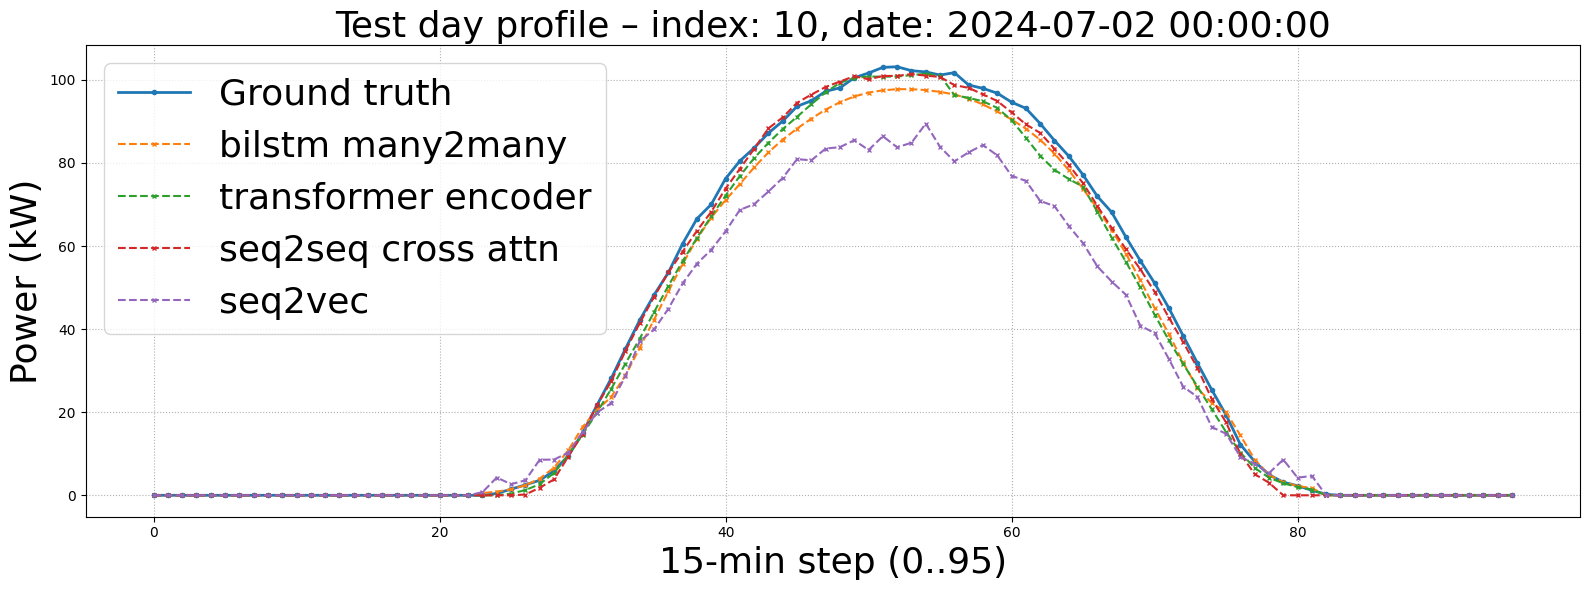

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_COMPLEX_DL_20260203_152147_day10.png (+.pdf)


In [12]:
# ============================================================
# OUTPUT / REPORTING BLOCK (KOD-2 STYLE) – COMPLEX DL (KOD-1)
#  - Same OUT_DIR as Kod-1:
#      C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs
#  - Adds: run-id prefixed CSVs + table figures + test-day profile save
#
# Produces:
#  (1) metrics_overall_COMPLEX_DL_<RUN_ID>.csv                  (ALL + DAY in one table)
#  (2) metrics_overall_daylight_COMPLEX_DL_<RUN_ID>.csv         (optional daylight-only)
#  (3) metrics_daily_COMPLEX_DL_<RUN_ID>_<model>.csv            (per model)
#  (4) best_model_COMPLEX_DL_<RUN_ID>.json                      (artifacts/)
#  (5) table figure overall (.png + .pdf)                       (figures/)
#  (6) table figure daylight-only (.png + .pdf) (optional)      (figures/)
#  (7) test day profile figure (.png + .pdf) + show             (figures/)
# ============================================================
from datetime import datetime

# --- Target directory: SAME AS KOD-1 OUT_DIR ---
OUT_DIR_KOD1 = OUT_DIR
ARTIFACT_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "artifacts")
FIG_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "figures")

os.makedirs(OUT_DIR_KOD1, exist_ok=True)
os.makedirs(ARTIFACT_DIR_KOD1, exist_ok=True)
os.makedirs(FIG_DIR_KOD1, exist_ok=True)

# --- RUN_ID / PREFIX ---
RUN_ID_SAFE = globals().get("RUN_ID", datetime.now().strftime("%Y%m%d_%H%M%S"))
PREFIX = f"COMPLEX_DL_{RUN_ID_SAFE}"

# ------------------------------------------------------------
# 1) Build KOD-1 style overall summary: ALL + DAY in ONE table
#    Your train_and_evaluate_model already returns a dict with:
#      MSE, RMSE, MAE, R2, and MSE_day, RMSE_day, MAE_day, R2_day
#    so we can directly tabulate it.
# ------------------------------------------------------------
summary_rows = []
for model_name, m in metrics_overall.items():
    row = dict(m)
    row["model"] = model_name
    summary_rows.append(row)

summary_df_k1fmt = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")

print("\n======================================")
print("COMPLEX DL – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED]  (KOD-1 FORMAT)")
print("======================================")
print(summary_df_k1fmt)

# Save overall metrics CSV into KOD-1 directory with run-id name (no overwrite)
summary_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_{PREFIX}.csv")
summary_df_k1fmt.to_csv(summary_path_k1)
print(f"[Saved] Overall metrics (KOD-1 dir) -> {summary_path_k1}")

# Best model by ALL-timestep RMSE
BEST_MODEL_NAME = summary_df_k1fmt.index[0]
print(f"[Best] {BEST_MODEL_NAME}")

best_payload_k1 = {
    "best_model_name": BEST_MODEL_NAME,
    "run_id": RUN_ID_SAFE,
    "source": "complex_dl (code1)",
    "sorted_by": "RMSE (ALL timesteps, post-processed)",
    "daylight_weight": float(globals().get("DAYLIGHT_WEIGHT", DAYLIGHT_WEIGHT)),
    "postprocess": {
        "clip_negative": bool(globals().get("CLIP_NEGATIVE", CLIP_NEGATIVE)),
        "night_zero": bool(globals().get("NIGHT_ZERO", NIGHT_ZERO)),
    },
    "selected_features": globals().get("selected_features", None),
}
best_path_k1 = os.path.join(ARTIFACT_DIR_KOD1, f"best_model_{PREFIX}.json")
with open(best_path_k1, "w", encoding="utf-8") as f:
    json.dump(best_payload_k1, f, ensure_ascii=False, indent=2)
print(f"[Saved] Best model payload (KOD-1 dir) -> {best_path_k1}")

# ------------------------------------------------------------
# 2) Save daily metrics per model into KOD-1 directory
# ------------------------------------------------------------
for model_name, df_daily in metrics_daily.items():
    daily_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_daily_{PREFIX}_{model_name}.csv")
    df_daily.to_csv(daily_path_k1)

print(f"[Saved] Daily metrics (per model) into KOD-1 dir: {OUT_DIR_KOD1}")

# ------------------------------------------------------------
# 3) Save tables as FIGURES (PNG + PDF) for paper-ready usage
# ------------------------------------------------------------
def _save_df_as_table_figure(df, title, png_path, pdf_path, max_rows=30, round_n=3):
    df2 = df.copy()
    if df2.shape[0] > int(max_rows):
        df2 = df2.head(int(max_rows))

    try:
        df2 = df2.round(int(round_n))
    except Exception:
        pass

    fig_h = max(2.5, 0.35 * (df2.shape[0] + 1))
    fig_w = max(10.0, 1.2 * (df2.shape[1] + 1))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    ax.set_title(title, fontsize=12, pad=12)

    tbl = ax.table(
        cellText=df2.values,
        rowLabels=df2.index.astype(str).tolist(),
        colLabels=df2.columns.astype(str).tolist(),
        loc="center"
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, 1.25)

    fig.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

# Overall table figure
table_overall_png = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.png")
table_overall_pdf = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.pdf")
_save_df_as_table_figure(
    summary_df_k1fmt,
    title=f"Overall Test Metrics (Complex DL) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
    png_path=table_overall_png,
    pdf_path=table_overall_pdf,
    max_rows=30,
    round_n=3
)
print(f"[Saved] Overall metrics TABLE figure -> {table_overall_png} (+.pdf)")

# Optional daylight-only overall table (if _day metrics exist)
day_cols = ["MSE_day", "RMSE_day", "MAE_day", "R2_day"]
if all(c in summary_df_k1fmt.columns for c in day_cols):
    summary_day_df = summary_df_k1fmt[day_cols].copy()
    # Rename to the “classic” naming (optional, makes it cleaner)
    summary_day_df = summary_day_df.rename(columns={
        "MSE_day": "MSE", "RMSE_day": "RMSE", "MAE_day": "MAE", "R2_day": "R2"
    }).sort_values("RMSE")

    day_csv_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_daylight_{PREFIX}.csv")
    summary_day_df.to_csv(day_csv_k1)

    day_png_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.png")
    day_pdf_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.pdf")
    _save_df_as_table_figure(
        summary_day_df,
        title=f"Daylight-Only Test Metrics (Complex DL) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
        png_path=day_png_k1,
        pdf_path=day_pdf_k1,
        max_rows=30,
        round_n=3
    )
    print(f"[Saved] Daylight-only overall metrics -> {day_csv_k1}")
    print(f"[Saved] Daylight-only TABLE figure -> {day_png_k1} (+.pdf)")

# # ------------------------------------------------------------
# # 4) Plot test-day profile (KOD-1 style) + SAVE PNG/PDF
# # ------------------------------------------------------------
# def plot_test_day_and_save(day_no, d_test, Y_test_orig_2d, preds_by_model_2d, prefix, fig_dir, model_list=None):
#     if d_test is None or len(d_test) == 0:
#         print("Empty test set, nothing to plot.")
#         return

#     if model_list is None:
#         model_list = list(preds_by_model_2d.keys())

#     unique_days = np.unique(d_test)
#     if day_no < 1 or day_no > len(unique_days):
#         print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
#         return

#     day_label = unique_days[day_no - 1]
#     idxs = np.where(d_test == day_label)[0]
#     if len(idxs) == 0:
#         print(f"No sample found for day {day_label}.")
#         return

#     y_true = np.asarray(Y_test_orig_2d)[idxs].reshape(-1)

#     plt.figure(figsize=(16, 6))
#     plt.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

#     for model_name in model_list:
#         if model_name not in preds_by_model_2d:
#             continue
#         y_pred_day = np.asarray(preds_by_model_2d[model_name])[idxs].reshape(-1)
#         plt.plot(y_pred_day, label=f"{model_name}", linestyle="--", marker="x", ms=3)

#     plt.title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=26)
#     plt.xlabel("15-min step (0..95)", fontsize=26)
#     plt.ylabel("Power (kW)", fontsize=26)
#     plt.grid(True, linestyle=":")
#     plt.legend(fontsize=26)
#     plt.tight_layout()

#     png_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.png")
#     pdf_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.pdf")
#     plt.savefig(png_path, dpi=300, bbox_inches="tight")
#     plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
#     plt.show()

#     print(f"[Saved] Test day profile figure -> {png_path} (+.pdf)")
import re

def _pretty_model_label(model_name: str) -> str:
    # 1) baştaki "model<number>_" kısmını kaldır (model1_, model2_ ...)
    s = re.sub(r"^model\d+_", "", model_name)

    # 2) istersen sondaki "_complex" etiketini kaldır
    s = re.sub(r"_complex$", "", s)

    # 3) istersen alt çizgileri boşluğa çevir (daha okunur)
    s = s.replace("_", " ")

    return s


def plot_test_day_and_save(day_no, d_test, Y_test_orig_2d, preds_by_model_2d,
                           prefix, fig_dir, model_list=None):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return

    if model_list is None:
        model_list = list(preds_by_model_2d.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = np.asarray(Y_test_orig_2d)[idxs].reshape(-1)

    plt.figure(figsize=(16, 6))
    plt.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model_2d:
            continue

        y_pred_day = np.asarray(preds_by_model_2d[model_name])[idxs].reshape(-1)

        display_name = _pretty_model_label(model_name)  # <-- kritik satır
        plt.plot(y_pred_day, label=display_name, linestyle="--", marker="x", ms=3)

    plt.title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=26)
    plt.xlabel("15-min step (0..95)", fontsize=26)
    plt.ylabel("Power (kW)", fontsize=26)
    plt.grid(True, linestyle=":")
    plt.legend(fontsize=26)
    plt.tight_layout()

    png_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.png")
    pdf_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.pdf")
    plt.savefig(png_path, dpi=300, bbox_inches="tight")
    plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"[Saved] Test day profile figure -> {png_path} (+.pdf)")

# Choose which models to plot (recommended: RMSE-sorted order)
models_sorted_for_plot = list(summary_df_k1fmt.index)

# Example plot day:
Y_test_for_plot = y_test_orig.squeeze(-1)  # (N,96)
EXAMPLE_DAY_NO = 10  # change as needed
print("\nExample plot (KOD-1 format + save): plot_test_day_and_save(EXAMPLE_DAY_NO, ...)")
plot_test_day_and_save(
    day_no=EXAMPLE_DAY_NO,
    d_test=d_test,
    Y_test_orig_2d=Y_test_for_plot,
    preds_by_model_2d=preds_by_model,
    prefix=PREFIX,
    fig_dir=FIG_DIR_KOD1,
    model_list=models_sorted_for_plot
)



Example plot (KOD-1 format + save): plot_test_day_and_save(EXAMPLE_DAY_NO, ...)


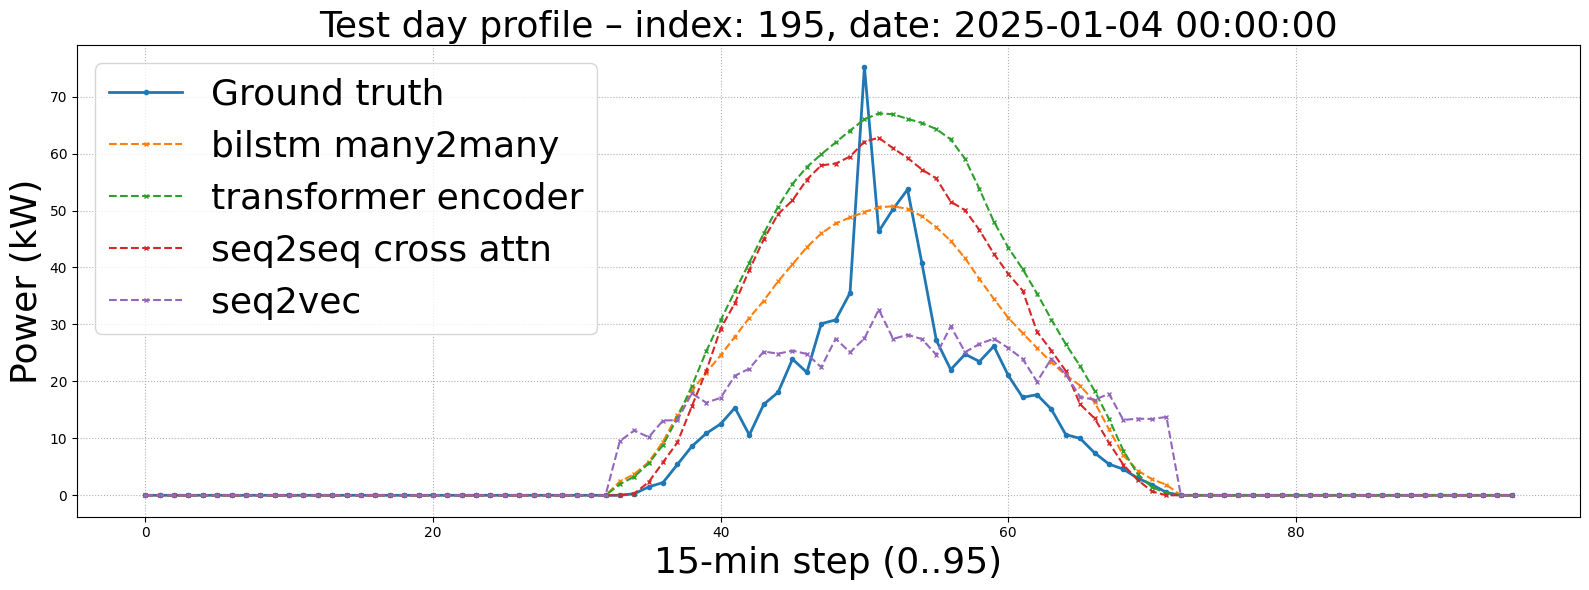

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_COMPLEX_DL_20260203_152147_day195.png (+.pdf)


In [14]:
# Example plot day:
Y_test_for_plot = y_test_orig.squeeze(-1)  # (N,96)
EXAMPLE_DAY_NO = 195  # change as needed
print("\nExample plot (KOD-1 format + save): plot_test_day_and_save(EXAMPLE_DAY_NO, ...)")
plot_test_day_and_save(
    day_no=EXAMPLE_DAY_NO,
    d_test=d_test,
    Y_test_orig_2d=Y_test_for_plot,
    preds_by_model_2d=preds_by_model,
    prefix=PREFIX,
    fig_dir=FIG_DIR_KOD1,
    model_list=models_sorted_for_plot
)


COMPLEX DL – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED] (KOD-1 FORMAT)
                                           MSE       RMSE       MAE        R2  \
model                                                                           
model4_bilstm_many2many_complex      89.996330   9.486640  3.884670  0.920164   
model2_transformer_encoder_complex   99.672226   9.983598  3.997297  0.911580   
model3_seq2seq_cross_attn_complex    99.825806   9.991286  4.034333  0.911444   
model1_seq2vec_complex              133.439957  11.551621  6.493351  0.881624   

                                     RMSE_day    MAE_day    R2_day     MSE_day  
model                                                                           
model4_bilstm_many2many_complex     13.482331   7.837009  0.844844  181.773254  
model2_transformer_encoder_complex  14.188631   8.064498  0.828162  201.317261  
model3_seq2seq_cross_attn_complex   14.199559   8.139306  0.827897  201.627472  
model1_seq2vec_compl

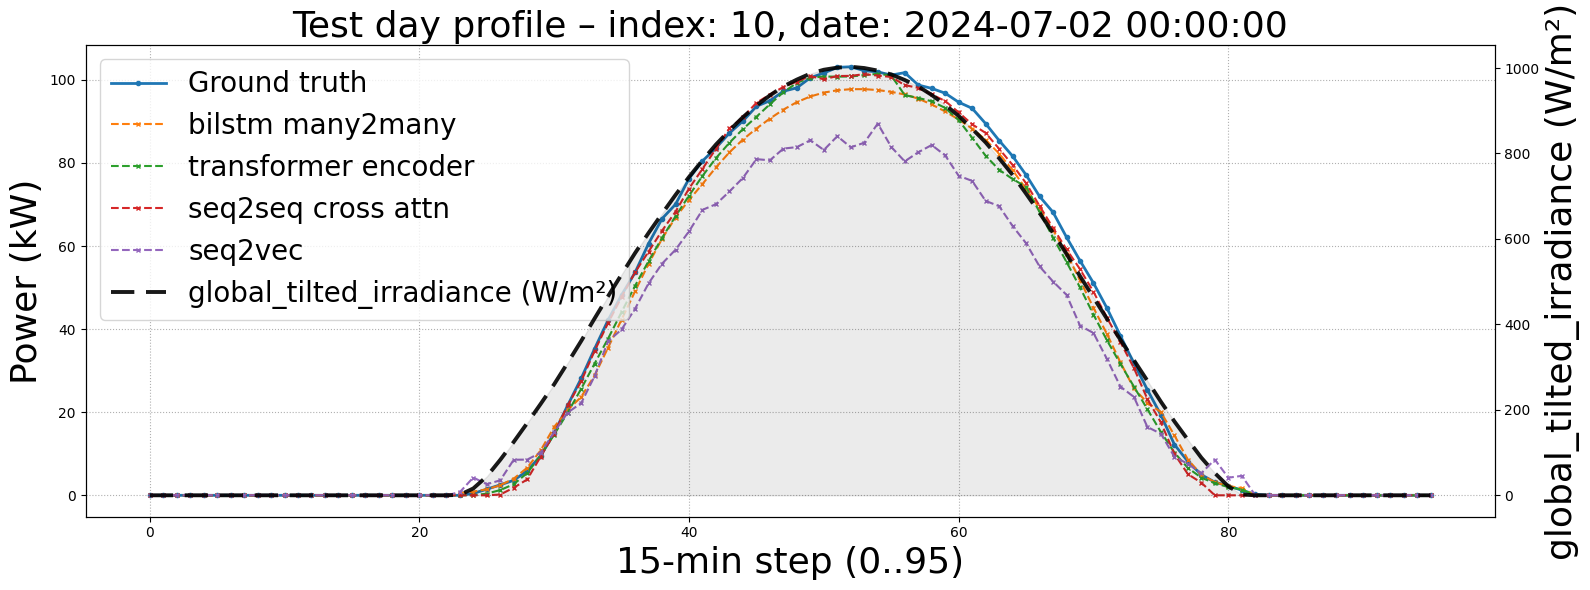

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_COMPLEX_DL_20260203_164420_day10.png (+.pdf)


In [25]:
# ============================================================
# OUTPUT / REPORTING BLOCK (KOD-2 STYLE) – COMPLEX DL (KOD-1)
#  - Same OUT_DIR as Kod-1
#  - Saves: run-id prefixed CSVs + table figures + test-day profile save
#  - Plots: Power (kW) + (optional) global_tilted_irradiance (W/m²) on 2nd y-axis
#
# Produces:
#  (1) metrics_overall_<PREFIX>.csv
#  (2) metrics_overall_daylight_<PREFIX>.csv (optional)
#  (3) metrics_daily_<PREFIX>_<model>.csv
#  (4) best_model_<PREFIX>.json (artifacts/)
#  (5) table_metrics_overall_<PREFIX>.png/.pdf
#  (6) table_metrics_overall_daylight_<PREFIX>.png/.pdf (optional)
#  (7) test_day_profile_<PREFIX>_day<k>.png/.pdf
# ============================================================

import os
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------
# 0) Sanity checks (required inputs)
# -----------------------------
required_vars = ["OUT_DIR", "metrics_overall", "metrics_daily"]
missing = [v for v in required_vars if v not in globals() or globals()[v] is None]
if missing:
    raise ValueError(f"Missing required variables in globals(): {missing}")

# -----------------------------
# 1) DIRECTORIES (same as KOD-1)
# -----------------------------
OUT_DIR_KOD1 = OUT_DIR
ARTIFACT_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "artifacts")
FIG_DIR_KOD1 = os.path.join(OUT_DIR_KOD1, "figures")

os.makedirs(OUT_DIR_KOD1, exist_ok=True)
os.makedirs(ARTIFACT_DIR_KOD1, exist_ok=True)
os.makedirs(FIG_DIR_KOD1, exist_ok=True)

# -----------------------------
# 2) RUN_ID / PREFIX
# -----------------------------
RUN_ID_SAFE = globals().get("RUN_ID", datetime.now().strftime("%Y%m%d_%H%M%S"))
PREFIX = f"COMPLEX_DL_{RUN_ID_SAFE}"

DAYLIGHT_WEIGHT_VAL = float(globals().get("DAYLIGHT_WEIGHT", 1.0))
CLIP_NEGATIVE_VAL = bool(globals().get("CLIP_NEGATIVE", True))
NIGHT_ZERO_VAL = bool(globals().get("NIGHT_ZERO", True))

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def _get_first_global(names):
    for n in names:
        if n in globals() and globals()[n] is not None:
            return globals()[n], n
    return None, None

def _pretty_model_label(model_name: str) -> str:
    s = re.sub(r"^model\d+_", "", model_name)   # remove "modelX_"
    s = re.sub(r"_complex$", "", s)             # remove "_complex" (optional)
    s = s.replace("_", " ")
    return s

# ------------------------------------------------------------
# 3) Overall summary table (ALL + DAY in ONE table)
#    Requires: metrics_overall dict
# ------------------------------------------------------------
summary_rows = []
for model_name, m in metrics_overall.items():
    row = dict(m)
    row["model"] = model_name
    summary_rows.append(row)

summary_df_k1fmt = pd.DataFrame(summary_rows).set_index("model").sort_values("RMSE")

print("\n======================================")
print("COMPLEX DL – TEST METRICS (OVERALL, DAY-AHEAD 96-STEP) [POST-PROCESSED] (KOD-1 FORMAT)")
print("======================================")
print(summary_df_k1fmt)

# Save overall metrics CSV
summary_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_{PREFIX}.csv")
summary_df_k1fmt.to_csv(summary_path_k1)
print(f"[Saved] Overall metrics -> {summary_path_k1}")

# Best model by ALL-timestep RMSE
BEST_MODEL_NAME = summary_df_k1fmt.index[0]
print(f"[Best] {BEST_MODEL_NAME}")

best_payload_k1 = {
    "best_model_name": BEST_MODEL_NAME,
    "run_id": RUN_ID_SAFE,
    "source": "complex_dl (code1)",
    "sorted_by": "RMSE (ALL timesteps, post-processed)",
    "daylight_weight": DAYLIGHT_WEIGHT_VAL,
    "postprocess": {
        "clip_negative": CLIP_NEGATIVE_VAL,
        "night_zero": NIGHT_ZERO_VAL,
    },
    "selected_features": globals().get("selected_features", None),
}
best_path_k1 = os.path.join(ARTIFACT_DIR_KOD1, f"best_model_{PREFIX}.json")
with open(best_path_k1, "w", encoding="utf-8") as f:
    json.dump(best_payload_k1, f, ensure_ascii=False, indent=2)
print(f"[Saved] Best model payload -> {best_path_k1}")

# ------------------------------------------------------------
# 4) Save daily metrics per model
#    Requires: metrics_daily dict of DataFrames
# ------------------------------------------------------------
for model_name, df_daily in metrics_daily.items():
    daily_path_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_daily_{PREFIX}_{model_name}.csv")
    df_daily.to_csv(daily_path_k1)

print(f"[Saved] Daily metrics (per model) into: {OUT_DIR_KOD1}")

# ------------------------------------------------------------
# 5) Save tables as FIGURES (PNG + PDF)
# ------------------------------------------------------------
def _save_df_as_table_figure(df, title, png_path, pdf_path, max_rows=30, round_n=3):
    df2 = df.copy()
    if df2.shape[0] > int(max_rows):
        df2 = df2.head(int(max_rows))

    try:
        df2 = df2.round(int(round_n))
    except Exception:
        pass

    fig_h = max(2.5, 0.35 * (df2.shape[0] + 1))
    fig_w = max(10.0, 1.2 * (df2.shape[1] + 1))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")
    ax.set_title(title, fontsize=12, pad=12)

    tbl = ax.table(
        cellText=df2.values,
        rowLabels=df2.index.astype(str).tolist(),
        colLabels=df2.columns.astype(str).tolist(),
        loc="center",
    )
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, 1.25)

    fig.tight_layout()
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

# Overall table figure
table_overall_png = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.png")
table_overall_pdf = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_{PREFIX}.pdf")
_save_df_as_table_figure(
    summary_df_k1fmt,
    title=f"Overall Test Metrics (Complex DL) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
    png_path=table_overall_png,
    pdf_path=table_overall_pdf,
    max_rows=30,
    round_n=3,
)
print(f"[Saved] Overall metrics TABLE figure -> {table_overall_png} (+.pdf)")

# Optional daylight-only overall table (if _day metrics exist)
day_cols = ["MSE_day", "RMSE_day", "MAE_day", "R2_day"]
if all(c in summary_df_k1fmt.columns for c in day_cols):
    summary_day_df = summary_df_k1fmt[day_cols].copy()
    summary_day_df = summary_day_df.rename(columns={
        "MSE_day": "MSE",
        "RMSE_day": "RMSE",
        "MAE_day": "MAE",
        "R2_day": "R2",
    }).sort_values("RMSE")

    day_csv_k1 = os.path.join(OUT_DIR_KOD1, f"metrics_overall_daylight_{PREFIX}.csv")
    summary_day_df.to_csv(day_csv_k1)

    day_png_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.png")
    day_pdf_k1 = os.path.join(FIG_DIR_KOD1, f"table_metrics_overall_daylight_{PREFIX}.pdf")
    _save_df_as_table_figure(
        summary_day_df,
        title=f"Daylight-Only Test Metrics (Complex DL) – Post-Processed (RUN_ID={RUN_ID_SAFE})",
        png_path=day_png_k1,
        pdf_path=day_pdf_k1,
        max_rows=30,
        round_n=3,
    )
    print(f"[Saved] Daylight-only overall metrics -> {day_csv_k1}")
    print(f"[Saved] Daylight-only TABLE figure -> {day_png_k1} (+.pdf)")

# ------------------------------------------------------------
# 6) Plot test-day profile + SAVE PNG/PDF
#    - Left axis: Power (kW)
#    - Right axis (optional): global_tilted_irradiance (W/m²)
# ------------------------------------------------------------
def plot_test_day_and_save(
    day_no,
    d_test,
    Y_test_orig_2d,
    preds_by_model_2d,
    prefix,
    fig_dir,
    model_list=None,
    gti_test_2d=None,  # (N,96) optional
    gti_name="global_tilted_irradiance (W/m²)",
):
    if d_test is None or len(d_test) == 0:
        print("Empty test set, nothing to plot.")
        return

    if model_list is None:
        model_list = list(preds_by_model_2d.keys())

    unique_days = np.unique(d_test)
    if day_no < 1 or day_no > len(unique_days):
        print(f"Invalid day_no={day_no}. There are {len(unique_days)} unique test days.")
        return

    day_label = unique_days[day_no - 1]
    idxs = np.where(d_test == day_label)[0]
    if len(idxs) == 0:
        print(f"No sample found for day {day_label}.")
        return

    y_true = np.asarray(Y_test_orig_2d)[idxs].reshape(-1)

    fig, ax1 = plt.subplots(figsize=(16, 6))

    # Power (kW) - left axis
    ax1.plot(y_true, label="Ground truth", marker="o", ms=3, linewidth=2)

    for model_name in model_list:
        if model_name not in preds_by_model_2d:
            continue
        y_pred_day = np.asarray(preds_by_model_2d[model_name])[idxs].reshape(-1)
        ax1.plot(
            y_pred_day,
            label=_pretty_model_label(model_name),
            linestyle="--",
            marker="x",
            ms=3
        )

    ax1.set_title(f"Test day profile – index: {day_no}, date: {day_label}", fontsize=26)
    ax1.set_xlabel("15-min step (0..95)", fontsize=26)
    ax1.set_ylabel("Power (kW)", fontsize=26)
    ax1.grid(True, linestyle=":")

    # GTI (W/m²) - right axis (optional)
    ax2 = None
    if gti_test_2d is not None:
        gti_day = np.asarray(gti_test_2d)[idxs].reshape(-1)
        ax2 = ax1.twinx()

        x = np.arange(len(gti_day))
        ax2.fill_between(
            x, 0, gti_day,
            color="black",
            alpha=0.08,             # <-- çok düşük dolgu (arka plan gibi)
            zorder=0
        )

        ax2.plot(
            gti_day,
            label=gti_name,
            color="black",
            linestyle=(0, (6, 3)),  # <-- uzun kesikli
            linewidth=2.8,
            alpha=0.9,
            zorder=1
        )

        ax2.set_ylabel(gti_name, fontsize=26)
        ax2.tick_params(axis="y", colors="black")
        ax2.spines["right"].set_color("black")


    # Single combined legend
    h1, l1 = ax1.get_legend_handles_labels()
    if ax2 is not None:
        h2, l2 = ax2.get_legend_handles_labels()
        ax1.legend(h1 + h2, l1 + l2, fontsize=20, loc="best")
    else:
        ax1.legend(fontsize=20, loc="best")

    fig.tight_layout()

    png_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.png")
    pdf_path = os.path.join(fig_dir, f"test_day_profile_{prefix}_day{day_no}.pdf")
    fig.savefig(png_path, dpi=300, bbox_inches="tight")
    fig.savefig(pdf_path, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close(fig)

    print(f"[Saved] Test day profile figure -> {png_path} (+.pdf)")

# ------------------------------------------------------------
# 7) Prepare GTI array (N,96) ROBUSTLY
# ------------------------------------------------------------
gti_test_2d = globals().get("gti_test_2d", None)

if gti_test_2d is None:
    # Try to find test feature tensor/array (3D preferred)
    Xcand, Xname = _get_first_global([
        "X_test_3d", "X_test", "x_test", "X_te", "X_test_seq", "X_test_scaled", "X_test_final"
    ])

    # Try to find feature name list
    Fcand, Fname = _get_first_global([
        "feature_names", "FEATURE_NAMES", "feature_cols", "FEATURE_COLS",
        "selected_features", "SELECTED_FEATURES"
    ])

    if Fcand is not None and not isinstance(Fcand, (list, tuple)):
        try:
            Fcand = list(Fcand)
        except Exception:
            pass

    gti_candidates = [
        "global_tilted_irradiance (W/m²)",
        "global_tilted_irradiance (W/m2)",
        "global_tilted_irradiance",
        "gti",
        "GTI",
    ]

    if (Xcand is not None) and (Fcand is not None):
        X = np.asarray(Xcand)
        feature_names = Fcand

        gti_idx = None
        for c in gti_candidates:
            if c in feature_names:
                gti_idx = feature_names.index(c)
                break

        if gti_idx is None:
            print(f"[Warn] GTI feature not found in {Fname}. Example features: {feature_names[:10]}")
        else:
            if X.ndim == 3:
                # (N,96,F)
                gti_test_2d = X[:, :, gti_idx]
                print(f"[Info] GTI extracted from {Xname} (3D) using '{feature_names[gti_idx]}' (idx={gti_idx})")
            elif X.ndim == 2:
                # attempt reshape if (N, 96*F)
                N = X.shape[0]
                if X.shape[1] % 96 == 0:
                    F = X.shape[1] // 96
                    if gti_idx < F:
                        X3 = X.reshape(N, 96, F)
                        gti_test_2d = X3[:, :, gti_idx]
                        print(f"[Info] GTI extracted from {Xname} (2D->3D reshape) using '{feature_names[gti_idx]}'")
                    else:
                        print(f"[Warn] gti_idx={gti_idx} >= F={F} after reshape. Check feature ordering.")
                else:
                    print(f"[Warn] {Xname} is 2D but not divisible by 96 -> cannot reshape safely. Shape={X.shape}")
            else:
                print(f"[Warn] {Xname} unexpected ndim={X.ndim}. Shape={X.shape}")

    # Fallback: try building from a test dataframe (15-min rows)
    if gti_test_2d is None:
        dfcand, dfname = _get_first_global(["df_test", "test_df", "df_te", "df_test_15min", "df_test_15m"])
        if dfcand is not None:
            df_test = dfcand.copy()

            dt_col = None
            for c in ["ds", "datetime", "timestamp", "time", "date_time"]:
                if c in df_test.columns:
                    dt_col = c
                    break

            gti_col = None
            for c in gti_candidates:
                if c in df_test.columns:
                    gti_col = c
                    break

            if dt_col is None:
                print(f"[Warn] {dfname} found but datetime column not found (expected ds/datetime/timestamp...).")
            elif gti_col is None:
                print(f"[Warn] {dfname} found but GTI column not found among candidates: {gti_candidates}")
            else:
                df_test[dt_col] = pd.to_datetime(df_test[dt_col])
                df_test = df_test.sort_values(dt_col)
                df_test["__day__"] = df_test[dt_col].dt.floor("D")

                gti_list = []
                for day, g in df_test.groupby("__day__"):
                    arr = g[gti_col].to_numpy()
                    if len(arr) >= 96:
                        gti_list.append(arr[:96])

                if len(gti_list) > 0:
                    gti_test_2d = np.vstack(gti_list)
                    print(f"[Info] GTI built from {dfname}[{gti_col}] -> shape={gti_test_2d.shape}")
                else:
                    print(f"[Warn] Could not build GTI matrix from {dfname}: no day had >=96 samples.")

if gti_test_2d is None:
    print("[Info] GTI still not available -> plotting WITHOUT GTI.")
else:
    arr = np.asarray(gti_test_2d)
    if arr.ndim != 2 or arr.shape[1] != 96:
        print(f"[Warn] gti_test_2d shape unexpected: {arr.shape} (expected (N,96))")

# ------------------------------------------------------------
# 8) Example: plot a test day (RMSE-sorted models) + save
#    Requires: d_test, y_test_orig, preds_by_model
# ------------------------------------------------------------
needed_for_plot = ["d_test", "y_test_orig", "preds_by_model"]
missing_plot = [v for v in needed_for_plot if v not in globals() or globals()[v] is None]
if missing_plot:
    print(f"[Warn] Missing for plotting: {missing_plot} -> skipping plot call.")
else:
    models_sorted_for_plot = list(summary_df_k1fmt.index)
    Y_test_for_plot = np.asarray(y_test_orig).squeeze(-1)  # (N,96)

    EXAMPLE_DAY_NO = 10  # change as needed

    print("\nExample plot: plot_test_day_and_save(EXAMPLE_DAY_NO, ...)")
    plot_test_day_and_save(
        day_no=EXAMPLE_DAY_NO,
        d_test=d_test,
        Y_test_orig_2d=Y_test_for_plot,
        preds_by_model_2d=preds_by_model,
        prefix=PREFIX,
        fig_dir=FIG_DIR_KOD1,
        model_list=models_sorted_for_plot,
        gti_test_2d=gti_test_2d,
        gti_name="global_tilted_irradiance (W/m²)",
    )



Example plot: plot_test_day_and_save(EXAMPLE_DAY_NO, ...)


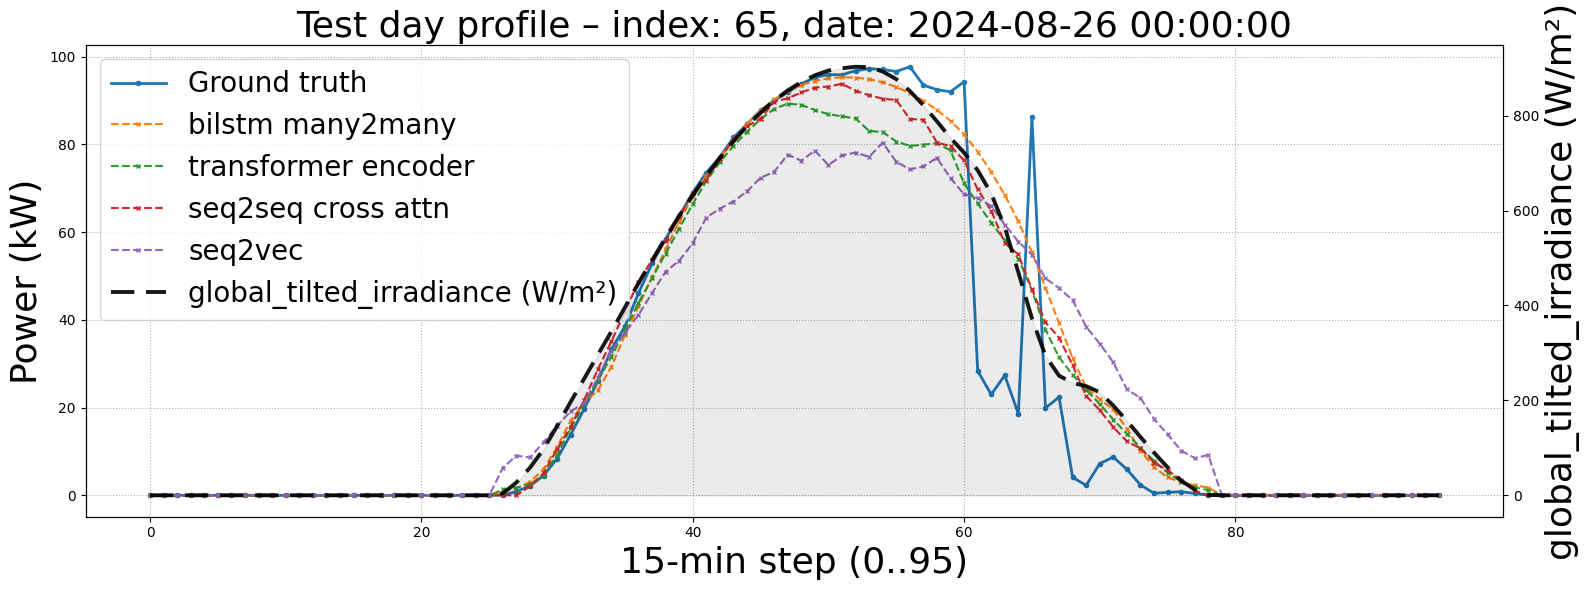

[Saved] Test day profile figure -> C:\Users\Admin\Desktop\Vedat\day_ahead_4models_outputs\figures\test_day_profile_COMPLEX_DL_20260203_164420_day65.png (+.pdf)


In [29]:
# ------------------------------------------------------------
# 8) Example: plot a test day (RMSE-sorted models) + save
#    Requires: d_test, y_test_orig, preds_by_model
# ------------------------------------------------------------
needed_for_plot = ["d_test", "y_test_orig", "preds_by_model"]
missing_plot = [v for v in needed_for_plot if v not in globals() or globals()[v] is None]
if missing_plot:
    print(f"[Warn] Missing for plotting: {missing_plot} -> skipping plot call.")
else:
    models_sorted_for_plot = list(summary_df_k1fmt.index)
    Y_test_for_plot = np.asarray(y_test_orig).squeeze(-1)  # (N,96)

    EXAMPLE_DAY_NO = 65  # change as needed

    print("\nExample plot: plot_test_day_and_save(EXAMPLE_DAY_NO, ...)")
    plot_test_day_and_save(
        day_no=EXAMPLE_DAY_NO,
        d_test=d_test,
        Y_test_orig_2d=Y_test_for_plot,
        preds_by_model_2d=preds_by_model,
        prefix=PREFIX,
        fig_dir=FIG_DIR_KOD1,
        model_list=models_sorted_for_plot,
        gti_test_2d=gti_test_2d,
        gti_name="global_tilted_irradiance (W/m²)",
    )